In [1]:
%cd /content
!rm -rf Gradu
!git clone https://github.com/Elkkujou/Gradu.git
%cd /content/Gradu
!ls

/content
Cloning into 'Gradu'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 246 (delta 55), reused 0 (delta 0), pack-reused 136 (from 1)
Receiving objects: 100% (246/246), 29.55 MiB | 9.15 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/Gradu
 chatti_RF.ipynb	       Regiimi_prediction.ipynb  'RF REGIIMI HYVÄ TRAINING.ipynb'
'Financial turbulence.ipynb'   regime_pred.txt		 'RF_regime (3).ipynb'
 FT_source.xlsx		       RF_Gradu.ipynb		  THE_ONE.xlsx


In [2]:
calc_drawdowns = True
drawdowns_from = 'Mkt-RF'
cluster_n = 3

DL = False
ML = True

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate

from IPython.display import display, HTML
from sklearn.cluster import KMeans

In [4]:
xls_file = pd.ExcelFile("/content/Gradu/THE_ONE.xlsx")
excel_df = xls_file.parse("Ajodata_1963")

excel_df.columns = excel_df.columns.get_level_values(0)
excel_df['Date'] = pd.to_datetime(excel_df['Date'])
excel_df.sort_values('Date', inplace=True)

print("Headers in the 'returns non-log' sheet:")
print(excel_df.columns)

Headers in the 'returns non-log' sheet:
Index(['Date', 'CPI', 'PPI', 'PCE_Price_Index', 'Unemployment_Rate',
       'Labor_Force_Participation', 'Fed_Funds_Rate', 'Treasury_10Y',
       'Treasury_3Mo', 'Moody_Baa_Yield', 'UMich_Consumer_Sentiment',
       'M1_Money_Stock', 'M2_Money_Stock', 'Comm_Industrial_Loans',
       'Housing_Starts', 'New_1Fam_Houses_Sold', 'Industrial_Production',
       'Crude_Oil_WTI', 'Nonfarm_Payrolls', 'Mkt-RF', 'SMB', 'HML', 'RMW',
       'CMA', 'RF', 'Winning Factor'],
      dtype='object')


In [5]:
if calc_drawdowns:
    # Calculate the cumulative portfolio values using excel_df and the specified drawdowns_from column
    portfolio = (1 + excel_df[drawdowns_from]).cumprod()

    # Define a function to compute the maximum drawdown over a rolling window
    def max_dd(s):
        return (s / s.cummax() - 1).min()

    # Calculate the 3-month rolling drawdown using the portfolio series
    dd_series = portfolio.rolling(window=3, min_periods=3).apply(max_dd, raw=False)

    # Create a temporary DataFrame to store dates and the calculated drawdowns
    dd_temp = pd.DataFrame({
        'Date': excel_df['Date'],
        '3M_Max_Drawdown': dd_series
    })

    # Drop rows with missing drawdown data to ensure complete observations
    dd_temp = dd_temp.dropna()

    print("Drawdown calculation (temporary DataFrame):")
    print(dd_temp.head())


Drawdown calculation (temporary DataFrame):
        Date  3M_Max_Drawdown
2 1963-10-01          -0.0157
3 1963-11-01          -0.0157
4 1963-12-01          -0.0085
5 1964-01-01          -0.0085
6 1964-02-01           0.0000


In [6]:
# Fit KMeans clustering on the temporary DataFrame's '3M_Max_Drawdown' column
kmeans = KMeans(n_clusters=cluster_n, random_state=42)
dd_temp['DD_cluster'] = kmeans.fit_predict(dd_temp[['3M_Max_Drawdown']])

# Merge the cluster labels from dd_temp into excel_df by matching on the 'Date' column.
# This adds a new column 'DD_cluster' to excel_df.
excel_df = excel_df.merge(dd_temp[['Date', 'DD_cluster']], on='Date', how='left')

print("excel_df with DD_cluster added:")
from IPython.display import display, HTML
display(HTML(excel_df.head().to_html(index=False)))


excel_df with DD_cluster added:


Date,CPI,PPI,PCE_Price_Index,Unemployment_Rate,Labor_Force_Participation,Fed_Funds_Rate,Treasury_10Y,Treasury_3Mo,Moody_Baa_Yield,UMich_Consumer_Sentiment,M1_Money_Stock,M2_Money_Stock,Comm_Industrial_Loans,Housing_Starts,New_1Fam_Houses_Sold,Industrial_Production,Crude_Oil_WTI,Nonfarm_Payrolls,Mkt-RF,SMB,HML,RMW,CMA,RF,Winning Factor,DD_cluster
1963-08-01,0.002614,0.003165,0.001992,5.6,58.7,3.49,4.00,3.32,4.84,91.7,0.005984,0.007135,0.004457,0.016373,0.264259,-0.003983,0.0,0.002383,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027,RMW,NaN
1963-09-01,0.001955,-0.003155,0.001367,5.4,58.5,3.48,4.08,3.38,4.83,96.4,0.003305,0.006560,0.000210,0.015489,-0.142857,0.001999,0.0,0.002042,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025,HML,NaN
1963-10-01,-0.000976,0.000000,-0.000186,5.5,58.7,3.50,4.11,3.45,4.84,96.4,0.001318,0.006257,0.006987,0.075656,0.035088,0.009970,0.0,0.002952,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027,CMA,1.0
1963-11-01,0.000977,0.000000,0.001924,5.5,58.8,3.48,4.12,3.52,4.83,96.4,0.003947,0.005959,0.011814,0.009075,-0.038983,0.006911,0.0,0.003592,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029,RMW,1.0
1963-12-01,0.000976,0.003165,0.001425,5.7,58.8,3.38,4.13,3.52,4.84,94.4,0.006553,0.008241,0.016407,-0.088252,0.021164,0.004902,0.0,-0.000489,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027,CMA,1.0


In [7]:
#FEATURES = ['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial condition', '10y-2y', 'Financial Turbulance']

FEATURES = [
    'CPI', 'PPI', 'PCE_Price_Index', 'Unemployment_Rate',
    'Labor_Force_Participation', 'Fed_Funds_Rate', 'Treasury_10Y',
    'Treasury_3Mo', 'Moody_Baa_Yield', 'UMich_Consumer_Sentiment',
    'M1_Money_Stock', 'M2_Money_Stock', 'Comm_Industrial_Loans',
    'Housing_Starts', 'New_1Fam_Houses_Sold', 'Industrial_Production',
    'Crude_Oil_WTI', 'Nonfarm_Payrolls'
]

TRUE_REGIME = 'DD_cluster'
DATE = 'Date'

selected_columns =  [DATE] + [TRUE_REGIME] +FEATURES


In [8]:
missing = [col for col in selected_columns if col not in excel_df.columns]
if missing:
    raise ValueError(f"Missing columns in df: {missing}")

# Subset and drop rows with empty values
input_df = excel_df[selected_columns]
orig_rows = len(input_df)
input_df = input_df.dropna()
print(f"Original rows: {orig_rows}, Dropped rows: {orig_rows - len(input_df)}")
print(f"First obs: {input_df[DATE].min()}, Last obs: {input_df[DATE].max()}")

# Display as neat HTML table (adjust 'rows_to_show' as needed)
rows_to_show = 10
from IPython.display import display, HTML
display(HTML(input_df.head(rows_to_show).to_html(index=False)))

Original rows: 737, Dropped rows: 2
First obs: 1963-10-01 00:00:00, Last obs: 2024-12-01 00:00:00


Date,DD_cluster,CPI,PPI,PCE_Price_Index,Unemployment_Rate,Labor_Force_Participation,Fed_Funds_Rate,Treasury_10Y,Treasury_3Mo,Moody_Baa_Yield,UMich_Consumer_Sentiment,M1_Money_Stock,M2_Money_Stock,Comm_Industrial_Loans,Housing_Starts,New_1Fam_Houses_Sold,Industrial_Production,Crude_Oil_WTI,Nonfarm_Payrolls
1963-10-01,1.0,-0.000976,0.000000,-0.000186,5.5,58.7,3.50,4.11,3.45,4.84,96.4,0.001318,0.006257,0.006987,0.075656,0.035088,0.009970,0.0,0.002952
1963-11-01,1.0,0.000977,0.000000,0.001924,5.5,58.8,3.48,4.12,3.52,4.83,96.4,0.003947,0.005959,0.011814,0.009075,-0.038983,0.006911,0.0,0.003592
1963-12-01,1.0,0.000976,0.003165,0.001425,5.7,58.8,3.38,4.13,3.52,4.84,94.4,0.006553,0.008241,0.016407,-0.088252,0.021164,0.004902,0.0,-0.000489
1964-01-01,1.0,0.003249,-0.003155,0.001485,5.5,58.5,3.48,4.17,3.52,4.85,94.4,-0.001953,0.004342,0.018266,-0.080764,-0.112263,-0.001953,0.0,0.001851
1964-02-01,1.0,0.001943,0.006329,0.002100,5.6,58.6,3.48,4.15,3.53,4.83,94.4,0.002609,0.005086,0.004686,0.075117,0.068093,0.008797,0.0,0.002197
1964-03-01,1.0,-0.000970,-0.006289,0.001418,5.4,58.8,3.43,4.22,3.54,4.83,99.5,0.003904,0.006073,0.002472,0.135371,0.109290,0.006784,0.0,0.004627
1964-04-01,1.0,0.000971,0.000000,0.000615,5.4,58.7,3.47,4.23,3.47,4.83,99.5,0.001296,0.005533,0.003153,-0.166484,-0.077176,0.000000,0.0,0.002493
1964-05-01,1.0,0.000323,0.000000,0.000738,5.3,59.1,3.50,4.20,3.48,4.85,99.5,0.001942,0.004752,0.009772,-0.045485,-0.005338,0.016363,0.0,0.000432
1964-06-01,1.0,0.000969,-0.003165,0.000123,5.1,59.1,3.50,4.17,3.48,4.85,98.5,0.003230,0.006224,0.009685,0.013122,-0.064401,0.005682,0.0,0.002883
1964-07-01,1.0,0.000968,0.000000,0.001414,5.2,58.7,3.42,4.19,3.46,4.85,98.5,0.001932,0.007175,0.010219,0.056578,0.108987,0.002823,0.0,0.002238


In [9]:
from tabulate import tabulate

# Calculate the number of observations for each regime in the data
regime_counts = input_df[TRUE_REGIME].value_counts().sort_index().reset_index()
regime_counts.columns = [TRUE_REGIME, 'Count']

print("Number of observations per regime:")
print(tabulate(regime_counts, headers='keys', tablefmt='psql', showindex=False))


Number of observations per regime:
+--------------+---------+
|   DD_cluster |   Count |
|--------------+---------|
|            0 |     190 |
|            1 |     513 |
|            2 |      32 |
+--------------+---------+


Starting rolling window evaluation:
Skipping prediction for timestamp 1963-10-01 00:00:00 (insufficient data: 0 observations available, need 60).
Skipping prediction for timestamp 1963-11-01 00:00:00 (insufficient data: 1 observations available, need 60).
Skipping prediction for timestamp 1963-12-01 00:00:00 (insufficient data: 2 observations available, need 60).
Skipping prediction for timestamp 1964-01-01 00:00:00 (insufficient data: 3 observations available, need 60).
Skipping prediction for timestamp 1964-02-01 00:00:00 (insufficient data: 4 observations available, need 60).
Skipping prediction for timestamp 1964-03-01 00:00:00 (insufficient data: 5 observations available, need 60).
Skipping prediction for timestamp 1964-04-01 00:00:00 (insufficient data: 6 observations available, need 60).
Skipping prediction for timestamp 1964-05-01 00:00:00 (insufficient data: 7 observations available, need 60).
Skipping prediction for timestamp 1964-06-01 00:00:00 (insufficient data: 8 observat

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1969-12-01 00:00:00 - Prediction for period 1970-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1969-12-01 00:00:00 - Prediction for period 1970-01-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1969-12-01 00:00:00 - Prediction for period 1970-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1970-01-01 00:00:00 - Prediction for period 1970-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1970-01-01 00:00:00 - Prediction for period 1970-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1970-01-01 00:00:00 - Prediction for period 1970-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1970-01-01 00:00:00 - Prediction for period 1970-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1970-01-01 00:00:00 - Prediction for period 1970-02-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1970-02-01 00:00:00 - Prediction for period 1970-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1970-02-01 00:00:00 - Prediction for period 1970-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1970-02-01 00:00:00 - Prediction for period 1970-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1970-03-01 00:00:00 - Prediction for period 1970-04-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1970-03-01 00:00:00 - Prediction for period 1970-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1970-03-01 00:00:00 - Prediction for period 1970-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1970-03-01 00:00:00 - Prediction for period 1970-04-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1970-03-01 00:00:00 - Prediction for period 1970-04-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1970-07-01 00:00:00 - Prediction for period 1970-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1970-07-01 00:00:00 - Prediction for period 1970-08-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1970-07-01 00:00:00 - Prediction for period 1970-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1970-08-01 00:00:00 - Prediction for period 1970-09-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1970-08-01 00:00:00 - Prediction for period 1970-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1970-08-01 00:00:00 - Prediction for period 1970-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1970-08-01 00:00:00 - Prediction for period 1970-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1970-08-01 00:00:00 - Prediction for period 1970-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1970-09-01 00:00:00 - Prediction for period 1970-10-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1970-09-01 00:00:00 - Prediction for period 1970-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1970-09-01 00:00:00 - Prediction for period 1970-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1970-09-01 00:00:00 - Prediction for period 1970-10-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1970-09-01 00:00:00 - Prediction for period 1970-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1970-10-01 00:00:00 - Prediction for period 1970-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1970-10-01 00:00:00 - Prediction for period 1970-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1970-10-01 00:00:00 - Prediction for period 1970-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1970-10-01 00:00:00 - Prediction for period 1970-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1970-10-01 00:00:00 - Prediction for period 1970-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1970-11-01 00:00:00 - Prediction for period 1970-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1970-11-01 00:00:00 - Prediction for period 1970-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1970-11-01 00:00:00 - Prediction for period 1970-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1970-11-01 00:00:00 - Prediction for period 1970-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1970-11-01 00:00:00 - Prediction for period 1970-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1970-12-01 00:00:00 - Prediction for period 1971-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1970-12-01 00:00:00 - Prediction for period 1971-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1970-12-01 00:00:00 - Prediction for period 1971-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1970-12-01 00:00:00 - Prediction for period 1971-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1970-12-01 00:00:00 - Prediction for period 1971-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1971-01-01 00:00:00 - Prediction for period 1971-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1971-01-01 00:00:00 - Prediction for period 1971-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1971-01-01 00:00:00 - Prediction for period 1971-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1971-01-01 00:00:00 - Prediction for period 1971-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1971-01-01 00:00:00 - Prediction for period 1971-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1971-02-01 00:00:00 - Prediction for period 1971-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1971-02-01 00:00:00 - Prediction for period 1971-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1971-02-01 00:00:00 - Prediction for period 1971-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1971-02-01 00:00:00 - Prediction for period 1971-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1971-02-01 00:00:00 - Prediction for period 1971-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1971-03-01 00:00:00 - Prediction for period 1971-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1971-03-01 00:00:00 - Prediction for period 1971-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1971-03-01 00:00:00 - Prediction for period 1971-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1971-03-01 00:00:00 - Prediction for period 1971-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1971-03-01 00:00:00 - Prediction for period 1971-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1971-04-01 00:00:00 - Prediction for period 1971-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1971-04-01 00:00:00 - Prediction for period 1971-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1971-04-01 00:00:00 - Prediction for period 1971-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1971-04-01 00:00:00 - Prediction for period 1971-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1971-04-01 00:00:00 - Prediction for period 1971-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1971-05-01 00:00:00 - Prediction for period 1971-06-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1971-05-01 00:00:00 - Prediction for period 1971-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1971-05-01 00:00:00 - Prediction for period 1971-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1971-05-01 00:00:00 - Prediction for period 1971-06-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1971-05-01 00:00:00 - Prediction for period 1971-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1971-06-01 00:00:00 - Prediction for period 1971-07-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1971-06-01 00:00:00 - Prediction for period 1971-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1971-06-01 00:00:00 - Prediction for period 1971-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1971-06-01 00:00:00 - Prediction for period 1971-07-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1971-06-01 00:00:00 - Prediction for period 1971-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1971-07-01 00:00:00 - Prediction for period 1971-08-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1971-07-01 00:00:00 - Prediction for period 1971-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1971-07-01 00:00:00 - Prediction for period 1971-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1971-07-01 00:00:00 - Prediction for period 1971-08-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1971-07-01 00:00:00 - Prediction for period 1971-08-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1971-09-01 00:00:00 - Prediction for period 1971-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1971-09-01 00:00:00 - Prediction for period 1971-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1971-09-01 00:00:00 - Prediction for period 1971-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1971-09-01 00:00:00 - Prediction for period 1971-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1971-09-01 00:00:00 - Prediction for period 1971-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1971-10-01 00:00:00 - Prediction for period 1971-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1971-10-01 00:00:00 - Prediction for period 1971-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1971-10-01 00:00:00 - Prediction for period 1971-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1971-10-01 00:00:00 - Prediction for period 1971-11-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1971-10-01 00:00:00 - Prediction for period 1971-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1971-11-01 00:00:00 - Prediction for period 1971-12-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1971-11-01 00:00:00 - Prediction for period 1971-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1971-11-01 00:00:00 - Prediction for period 1971-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1971-11-01 00:00:00 - Prediction for period 1971-12-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1971-11-01 00:00:00 - Prediction for period 1971-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1971-12-01 00:00:00 - Prediction for period 1972-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1971-12-01 00:00:00 - Prediction for period 1972-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1971-12-01 00:00:00 - Prediction for period 1972-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1971-12-01 00:00:00 - Prediction for period 1972-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1971-12-01 00:00:00 - Prediction for period 1972-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1972-01-01 00:00:00 - Prediction for period 1972-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1972-01-01 00:00:00 - Prediction for period 1972-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1972-01-01 00:00:00 - Prediction for period 1972-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1972-01-01 00:00:00 - Prediction for period 1972-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1972-01-01 00:00:00 - Prediction for period 1972-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1972-02-01 00:00:00 - Prediction for period 1972-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1972-02-01 00:00:00 - Prediction for period 1972-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1972-02-01 00:00:00 - Prediction for period 1972-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1972-02-01 00:00:00 - Prediction for period 1972-03-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1972-02-01 00:00:00 - Prediction for period 1972-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1972-03-01 00:00:00 - Prediction for period 1972-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1972-03-01 00:00:00 - Prediction for period 1972-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1972-03-01 00:00:00 - Prediction for period 1972-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1972-03-01 00:00:00 - Prediction for period 1972-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1972-03-01 00:00:00 - Prediction for period 1972-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1972-04-01 00:00:00 - Prediction for period 1972-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1972-04-01 00:00:00 - Prediction for period 1972-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1972-04-01 00:00:00 - Prediction for period 1972-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1972-04-01 00:00:00 - Prediction for period 1972-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1972-04-01 00:00:00 - Prediction for period 1972-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1972-05-01 00:00:00 - Prediction for period 1972-06-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1972-05-01 00:00:00 - Prediction for period 1972-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1972-05-01 00:00:00 - Prediction for period 1972-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1972-05-01 00:00:00 - Prediction for period 1972-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1972-05-01 00:00:00 - Prediction for period 1972-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1972-06-01 00:00:00 - Prediction for period 1972-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1972-06-01 00:00:00 - Prediction for period 1972-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1972-06-01 00:00:00 - Prediction for period 1972-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1972-06-01 00:00:00 - Prediction for period 1972-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1972-06-01 00:00:00 - Prediction for period 1972-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1972-07-01 00:00:00 - Prediction for period 1972-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1972-07-01 00:00:00 - Prediction for period 1972-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1972-07-01 00:00:00 - Prediction for period 1972-08-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1972-08-01 00:00:00 - Prediction for period 1972-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1972-08-01 00:00:00 - Prediction for period 1972-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1972-08-01 00:00:00 - Prediction for period 1972-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1972-08-01 00:00:00 - Prediction for period 1972-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1972-08-01 00:00:00 - Prediction for period 1972-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1972-09-01 00:00:00 - Prediction for period 1972-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1972-09-01 00:00:00 - Prediction for period 1972-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1972-09-01 00:00:00 - Prediction for period 1972-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1972-09-01 00:00:00 - Prediction for period 1972-10-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1972-09-01 00:00:00 - Prediction for period 1972-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1972-10-01 00:00:00 - Prediction for period 1972-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1972-10-01 00:00:00 - Prediction for period 1972-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1972-10-01 00:00:00 - Prediction for period 1972-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1972-10-01 00:00:00 - Prediction for period 1972-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1972-10-01 00:00:00 - Prediction for period 1972-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1972-11-01 00:00:00 - Prediction for period 1972-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1972-11-01 00:00:00 - Prediction for period 1972-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1972-11-01 00:00:00 - Prediction for period 1972-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1972-11-01 00:00:00 - Prediction for period 1972-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1972-11-01 00:00:00 - Prediction for period 1972-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1972-12-01 00:00:00 - Prediction for period 1973-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1972-12-01 00:00:00 - Prediction for period 1973-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1972-12-01 00:00:00 - Prediction for period 1973-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1972-12-01 00:00:00 - Prediction for period 1973-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1972-12-01 00:00:00 - Prediction for period 1973-01-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1973-01-01 00:00:00 - Prediction for period 1973-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1973-01-01 00:00:00 - Prediction for period 1973-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1973-01-01 00:00:00 - Prediction for period 1973-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1973-01-01 00:00:00 - Prediction for period 1973-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1973-01-01 00:00:00 - Prediction for period 1973-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1973-02-01 00:00:00 - Prediction for period 1973-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1973-02-01 00:00:00 - Prediction for period 1973-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1973-02-01 00:00:00 - Prediction for period 1973-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1973-02-01 00:00:00 - Prediction for period 1973-03-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1973-02-01 00:00:00 - Prediction for period 1973-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1973-03-01 00:00:00 - Prediction for period 1973-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1973-03-01 00:00:00 - Prediction for period 1973-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1973-03-01 00:00:00 - Prediction for period 1973-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1973-03-01 00:00:00 - Prediction for period 1973-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1973-03-01 00:00:00 - Prediction for period 1973-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1973-04-01 00:00:00 - Prediction for period 1973-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1973-04-01 00:00:00 - Prediction for period 1973-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1973-04-01 00:00:00 - Prediction for period 1973-05-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1973-05-01 00:00:00 - Prediction for period 1973-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1973-05-01 00:00:00 - Prediction for period 1973-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1973-05-01 00:00:00 - Prediction for period 1973-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1973-05-01 00:00:00 - Prediction for period 1973-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1973-05-01 00:00:00 - Prediction for period 1973-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1973-06-01 00:00:00 - Prediction for period 1973-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1973-06-01 00:00:00 - Prediction for period 1973-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1973-06-01 00:00:00 - Prediction for period 1973-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1973-06-01 00:00:00 - Prediction for period 1973-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1973-06-01 00:00:00 - Prediction for period 1973-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1973-07-01 00:00:00 - Prediction for period 1973-08-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1973-07-01 00:00:00 - Prediction for period 1973-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1973-07-01 00:00:00 - Prediction for period 1973-08-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1973-09-01 00:00:00 - Prediction for period 1973-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1973-09-01 00:00:00 - Prediction for period 1973-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1973-09-01 00:00:00 - Prediction for period 1973-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1973-09-01 00:00:00 - Prediction for period 1973-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1973-09-01 00:00:00 - Prediction for period 1973-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1973-10-01 00:00:00 - Prediction for period 1973-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1973-10-01 00:00:00 - Prediction for period 1973-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1973-10-01 00:00:00 - Prediction for period 1973-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1973-10-01 00:00:00 - Prediction for period 1973-11-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1973-10-01 00:00:00 - Prediction for period 1973-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1973-11-01 00:00:00 - Prediction for period 1973-12-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1973-11-01 00:00:00 - Prediction for period 1973-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1973-11-01 00:00:00 - Prediction for period 1973-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1973-11-01 00:00:00 - Prediction for period 1973-12-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1973-11-01 00:00:00 - Prediction for period 1973-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1973-12-01 00:00:00 - Prediction for period 1974-01-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1973-12-01 00:00:00 - Prediction for period 1974-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1973-12-01 00:00:00 - Prediction for period 1974-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1973-12-01 00:00:00 - Prediction for period 1974-01-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1973-12-01 00:00:00 - Prediction for period 1974-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1974-01-01 00:00:00 - Prediction for period 1974-02-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1974-01-01 00:00:00 - Prediction for period 1974-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1974-01-01 00:00:00 - Prediction for period 1974-02-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1974-02-01 00:00:00 - Prediction for period 1974-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1974-02-01 00:00:00 - Prediction for period 1974-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1974-02-01 00:00:00 - Prediction for period 1974-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1974-02-01 00:00:00 - Prediction for period 1974-03-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1974-02-01 00:00:00 - Prediction for period 1974-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1974-03-01 00:00:00 - Prediction for period 1974-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1974-03-01 00:00:00 - Prediction for period 1974-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1974-03-01 00:00:00 - Prediction for period 1974-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1974-03-01 00:00:00 - Prediction for period 1974-04-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1974-03-01 00:00:00 - Prediction for period 1974-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1974-04-01 00:00:00 - Prediction for period 1974-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1974-04-01 00:00:00 - Prediction for period 1974-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1974-04-01 00:00:00 - Prediction for period 1974-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1974-04-01 00:00:00 - Prediction for period 1974-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1974-04-01 00:00:00 - Prediction for period 1974-05-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1974-05-01 00:00:00 - Prediction for period 1974-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1974-05-01 00:00:00 - Prediction for period 1974-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1974-05-01 00:00:00 - Prediction for period 1974-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1974-05-01 00:00:00 - Prediction for period 1974-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1974-05-01 00:00:00 - Prediction for period 1974-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1974-06-01 00:00:00 - Prediction for period 1974-07-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1974-06-01 00:00:00 - Prediction for period 1974-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1974-06-01 00:00:00 - Prediction for period 1974-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1974-06-01 00:00:00 - Prediction for period 1974-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1974-06-01 00:00:00 - Prediction for period 1974-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1974-07-01 00:00:00 - Prediction for period 1974-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1974-07-01 00:00:00 - Prediction for period 1974-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1974-07-01 00:00:00 - Prediction for period 1974-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1974-07-01 00:00:00 - Prediction for period 1974-08-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1974-07-01 00:00:00 - Prediction for period 1974-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1974-08-01 00:00:00 - Prediction for period 1974-09-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1974-08-01 00:00:00 - Prediction for period 1974-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1974-08-01 00:00:00 - Prediction for period 1974-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1974-08-01 00:00:00 - Prediction for period 1974-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1974-08-01 00:00:00 - Prediction for period 1974-09-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1974-09-01 00:00:00 - Prediction for period 1974-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1974-09-01 00:00:00 - Prediction for period 1974-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1974-09-01 00:00:00 - Prediction for period 1974-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1974-09-01 00:00:00 - Prediction for period 1974-10-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1974-09-01 00:00:00 - Prediction for period 1974-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1974-10-01 00:00:00 - Prediction for period 1974-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1974-10-01 00:00:00 - Prediction for period 1974-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1974-10-01 00:00:00 - Prediction for period 1974-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1974-10-01 00:00:00 - Prediction for period 1974-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1974-10-01 00:00:00 - Prediction for period 1974-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1974-11-01 00:00:00 - Prediction for period 1974-12-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1974-11-01 00:00:00 - Prediction for period 1974-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1974-11-01 00:00:00 - Prediction for period 1974-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1974-11-01 00:00:00 - Prediction for period 1974-12-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1974-11-01 00:00:00 - Prediction for period 1974-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1974-12-01 00:00:00 - Prediction for period 1975-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1974-12-01 00:00:00 - Prediction for period 1975-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1974-12-01 00:00:00 - Prediction for period 1975-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1974-12-01 00:00:00 - Prediction for period 1975-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1974-12-01 00:00:00 - Prediction for period 1975-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1975-01-01 00:00:00 - Prediction for period 1975-02-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1975-01-01 00:00:00 - Prediction for period 1975-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1975-01-01 00:00:00 - Prediction for period 1975-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1975-01-01 00:00:00 - Prediction for period 1975-02-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1975-01-01 00:00:00 - Prediction for period 1975-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1975-02-01 00:00:00 - Prediction for period 1975-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1975-02-01 00:00:00 - Prediction for period 1975-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1975-02-01 00:00:00 - Prediction for period 1975-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1975-02-01 00:00:00 - Prediction for period 1975-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1975-02-01 00:00:00 - Prediction for period 1975-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1975-03-01 00:00:00 - Prediction for period 1975-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1975-03-01 00:00:00 - Prediction for period 1975-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1975-03-01 00:00:00 - Prediction for period 1975-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1975-03-01 00:00:00 - Prediction for period 1975-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1975-03-01 00:00:00 - Prediction for period 1975-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1975-04-01 00:00:00 - Prediction for period 1975-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1975-04-01 00:00:00 - Prediction for period 1975-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1975-04-01 00:00:00 - Prediction for period 1975-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1975-04-01 00:00:00 - Prediction for period 1975-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1975-04-01 00:00:00 - Prediction for period 1975-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1975-05-01 00:00:00 - Prediction for period 1975-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1975-05-01 00:00:00 - Prediction for period 1975-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1975-05-01 00:00:00 - Prediction for period 1975-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1975-05-01 00:00:00 - Prediction for period 1975-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1975-05-01 00:00:00 - Prediction for period 1975-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1975-06-01 00:00:00 - Prediction for period 1975-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1975-06-01 00:00:00 - Prediction for period 1975-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1975-06-01 00:00:00 - Prediction for period 1975-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1975-06-01 00:00:00 - Prediction for period 1975-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1975-06-01 00:00:00 - Prediction for period 1975-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1975-07-01 00:00:00 - Prediction for period 1975-08-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1975-07-01 00:00:00 - Prediction for period 1975-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1975-07-01 00:00:00 - Prediction for period 1975-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1975-07-01 00:00:00 - Prediction for period 1975-08-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1975-07-01 00:00:00 - Prediction for period 1975-08-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1975-08-01 00:00:00 - Prediction for period 1975-09-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1975-08-01 00:00:00 - Prediction for period 1975-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1975-08-01 00:00:00 - Prediction for period 1975-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1975-08-01 00:00:00 - Prediction for period 1975-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1975-08-01 00:00:00 - Prediction for period 1975-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1975-09-01 00:00:00 - Prediction for period 1975-10-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1975-09-01 00:00:00 - Prediction for period 1975-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1975-09-01 00:00:00 - Prediction for period 1975-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1975-09-01 00:00:00 - Prediction for period 1975-10-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1975-09-01 00:00:00 - Prediction for period 1975-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1975-10-01 00:00:00 - Prediction for period 1975-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1975-10-01 00:00:00 - Prediction for period 1975-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1975-10-01 00:00:00 - Prediction for period 1975-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1975-10-01 00:00:00 - Prediction for period 1975-11-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1975-10-01 00:00:00 - Prediction for period 1975-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1975-11-01 00:00:00 - Prediction for period 1975-12-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1975-11-01 00:00:00 - Prediction for period 1975-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1975-11-01 00:00:00 - Prediction for period 1975-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1975-11-01 00:00:00 - Prediction for period 1975-12-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1975-11-01 00:00:00 - Prediction for period 1975-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1975-12-01 00:00:00 - Prediction for period 1976-01-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1975-12-01 00:00:00 - Prediction for period 1976-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1975-12-01 00:00:00 - Prediction for period 1976-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1975-12-01 00:00:00 - Prediction for period 1976-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1975-12-01 00:00:00 - Prediction for period 1976-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1976-01-01 00:00:00 - Prediction for period 1976-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1976-01-01 00:00:00 - Prediction for period 1976-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1976-01-01 00:00:00 - Prediction for period 1976-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1976-01-01 00:00:00 - Prediction for period 1976-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1976-01-01 00:00:00 - Prediction for period 1976-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1976-02-01 00:00:00 - Prediction for period 1976-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1976-02-01 00:00:00 - Prediction for period 1976-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1976-02-01 00:00:00 - Prediction for period 1976-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1976-02-01 00:00:00 - Prediction for period 1976-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1976-02-01 00:00:00 - Prediction for period 1976-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1976-03-01 00:00:00 - Prediction for period 1976-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1976-03-01 00:00:00 - Prediction for period 1976-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1976-03-01 00:00:00 - Prediction for period 1976-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1976-03-01 00:00:00 - Prediction for period 1976-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1976-03-01 00:00:00 - Prediction for period 1976-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1976-04-01 00:00:00 - Prediction for period 1976-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1976-04-01 00:00:00 - Prediction for period 1976-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1976-04-01 00:00:00 - Prediction for period 1976-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1976-04-01 00:00:00 - Prediction for period 1976-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1976-04-01 00:00:00 - Prediction for period 1976-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1976-05-01 00:00:00 - Prediction for period 1976-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1976-05-01 00:00:00 - Prediction for period 1976-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1976-05-01 00:00:00 - Prediction for period 1976-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1976-05-01 00:00:00 - Prediction for period 1976-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1976-05-01 00:00:00 - Prediction for period 1976-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1976-06-01 00:00:00 - Prediction for period 1976-07-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1976-06-01 00:00:00 - Prediction for period 1976-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1976-06-01 00:00:00 - Prediction for period 1976-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1976-06-01 00:00:00 - Prediction for period 1976-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1976-06-01 00:00:00 - Prediction for period 1976-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1976-07-01 00:00:00 - Prediction for period 1976-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1976-07-01 00:00:00 - Prediction for period 1976-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1976-07-01 00:00:00 - Prediction for period 1976-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1976-07-01 00:00:00 - Prediction for period 1976-08-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1976-07-01 00:00:00 - Prediction for period 1976-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1976-08-01 00:00:00 - Prediction for period 1976-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1976-08-01 00:00:00 - Prediction for period 1976-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1976-08-01 00:00:00 - Prediction for period 1976-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1976-08-01 00:00:00 - Prediction for period 1976-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1976-08-01 00:00:00 - Prediction for period 1976-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1976-09-01 00:00:00 - Prediction for period 1976-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1976-09-01 00:00:00 - Prediction for period 1976-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1976-09-01 00:00:00 - Prediction for period 1976-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1976-09-01 00:00:00 - Prediction for period 1976-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1976-09-01 00:00:00 - Prediction for period 1976-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1976-10-01 00:00:00 - Prediction for period 1976-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1976-10-01 00:00:00 - Prediction for period 1976-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1976-10-01 00:00:00 - Prediction for period 1976-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1976-10-01 00:00:00 - Prediction for period 1976-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1976-10-01 00:00:00 - Prediction for period 1976-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1976-11-01 00:00:00 - Prediction for period 1976-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1976-11-01 00:00:00 - Prediction for period 1976-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1976-11-01 00:00:00 - Prediction for period 1976-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1976-11-01 00:00:00 - Prediction for period 1976-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1976-11-01 00:00:00 - Prediction for period 1976-12-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1976-12-01 00:00:00 - Prediction for period 1977-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1976-12-01 00:00:00 - Prediction for period 1977-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1976-12-01 00:00:00 - Prediction for period 1977-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1976-12-01 00:00:00 - Prediction for period 1977-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1976-12-01 00:00:00 - Prediction for period 1977-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1977-01-01 00:00:00 - Prediction for period 1977-02-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1977-01-01 00:00:00 - Prediction for period 1977-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1977-01-01 00:00:00 - Prediction for period 1977-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1977-01-01 00:00:00 - Prediction for period 1977-02-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1977-01-01 00:00:00 - Prediction for period 1977-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1977-02-01 00:00:00 - Prediction for period 1977-03-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1977-02-01 00:00:00 - Prediction for period 1977-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1977-02-01 00:00:00 - Prediction for period 1977-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1977-02-01 00:00:00 - Prediction for period 1977-03-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1977-02-01 00:00:00 - Prediction for period 1977-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1977-03-01 00:00:00 - Prediction for period 1977-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1977-03-01 00:00:00 - Prediction for period 1977-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1977-03-01 00:00:00 - Prediction for period 1977-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1977-03-01 00:00:00 - Prediction for period 1977-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1977-03-01 00:00:00 - Prediction for period 1977-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1977-04-01 00:00:00 - Prediction for period 1977-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1977-04-01 00:00:00 - Prediction for period 1977-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1977-04-01 00:00:00 - Prediction for period 1977-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1977-04-01 00:00:00 - Prediction for period 1977-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1977-04-01 00:00:00 - Prediction for period 1977-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1977-05-01 00:00:00 - Prediction for period 1977-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1977-05-01 00:00:00 - Prediction for period 1977-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1977-05-01 00:00:00 - Prediction for period 1977-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1977-05-01 00:00:00 - Prediction for period 1977-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1977-05-01 00:00:00 - Prediction for period 1977-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1977-06-01 00:00:00 - Prediction for period 1977-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1977-06-01 00:00:00 - Prediction for period 1977-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1977-06-01 00:00:00 - Prediction for period 1977-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1977-06-01 00:00:00 - Prediction for period 1977-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1977-06-01 00:00:00 - Prediction for period 1977-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1977-07-01 00:00:00 - Prediction for period 1977-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1977-07-01 00:00:00 - Prediction for period 1977-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1977-07-01 00:00:00 - Prediction for period 1977-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1977-07-01 00:00:00 - Prediction for period 1977-08-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1977-07-01 00:00:00 - Prediction for period 1977-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1977-08-01 00:00:00 - Prediction for period 1977-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1977-08-01 00:00:00 - Prediction for period 1977-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1977-08-01 00:00:00 - Prediction for period 1977-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1977-08-01 00:00:00 - Prediction for period 1977-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1977-08-01 00:00:00 - Prediction for period 1977-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1977-09-01 00:00:00 - Prediction for period 1977-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1977-09-01 00:00:00 - Prediction for period 1977-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1977-09-01 00:00:00 - Prediction for period 1977-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1977-09-01 00:00:00 - Prediction for period 1977-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1977-09-01 00:00:00 - Prediction for period 1977-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1977-10-01 00:00:00 - Prediction for period 1977-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1977-10-01 00:00:00 - Prediction for period 1977-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1977-10-01 00:00:00 - Prediction for period 1977-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1977-10-01 00:00:00 - Prediction for period 1977-11-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1977-10-01 00:00:00 - Prediction for period 1977-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1977-11-01 00:00:00 - Prediction for period 1977-12-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1977-11-01 00:00:00 - Prediction for period 1977-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1977-11-01 00:00:00 - Prediction for period 1977-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1977-11-01 00:00:00 - Prediction for period 1977-12-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1977-11-01 00:00:00 - Prediction for period 1977-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1977-12-01 00:00:00 - Prediction for period 1978-01-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1977-12-01 00:00:00 - Prediction for period 1978-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1977-12-01 00:00:00 - Prediction for period 1978-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1977-12-01 00:00:00 - Prediction for period 1978-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1977-12-01 00:00:00 - Prediction for period 1978-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1978-01-01 00:00:00 - Prediction for period 1978-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1978-01-01 00:00:00 - Prediction for period 1978-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1978-01-01 00:00:00 - Prediction for period 1978-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1978-01-01 00:00:00 - Prediction for period 1978-02-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1978-01-01 00:00:00 - Prediction for period 1978-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1978-02-01 00:00:00 - Prediction for period 1978-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1978-02-01 00:00:00 - Prediction for period 1978-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1978-02-01 00:00:00 - Prediction for period 1978-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1978-02-01 00:00:00 - Prediction for period 1978-03-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1978-02-01 00:00:00 - Prediction for period 1978-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1978-03-01 00:00:00 - Prediction for period 1978-04-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1978-03-01 00:00:00 - Prediction for period 1978-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1978-03-01 00:00:00 - Prediction for period 1978-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1978-03-01 00:00:00 - Prediction for period 1978-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1978-03-01 00:00:00 - Prediction for period 1978-04-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1978-04-01 00:00:00 - Prediction for period 1978-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1978-04-01 00:00:00 - Prediction for period 1978-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1978-04-01 00:00:00 - Prediction for period 1978-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1978-04-01 00:00:00 - Prediction for period 1978-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1978-04-01 00:00:00 - Prediction for period 1978-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1978-05-01 00:00:00 - Prediction for period 1978-06-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1978-05-01 00:00:00 - Prediction for period 1978-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1978-05-01 00:00:00 - Prediction for period 1978-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1978-05-01 00:00:00 - Prediction for period 1978-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1978-05-01 00:00:00 - Prediction for period 1978-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1978-06-01 00:00:00 - Prediction for period 1978-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1978-06-01 00:00:00 - Prediction for period 1978-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1978-06-01 00:00:00 - Prediction for period 1978-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1978-06-01 00:00:00 - Prediction for period 1978-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1978-06-01 00:00:00 - Prediction for period 1978-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1978-07-01 00:00:00 - Prediction for period 1978-08-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1978-07-01 00:00:00 - Prediction for period 1978-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1978-07-01 00:00:00 - Prediction for period 1978-08-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1978-08-01 00:00:00 - Prediction for period 1978-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1978-08-01 00:00:00 - Prediction for period 1978-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1978-08-01 00:00:00 - Prediction for period 1978-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1978-08-01 00:00:00 - Prediction for period 1978-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1978-08-01 00:00:00 - Prediction for period 1978-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1978-09-01 00:00:00 - Prediction for period 1978-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1978-09-01 00:00:00 - Prediction for period 1978-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1978-09-01 00:00:00 - Prediction for period 1978-10-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1978-10-01 00:00:00 - Prediction for period 1978-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1978-10-01 00:00:00 - Prediction for period 1978-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1978-10-01 00:00:00 - Prediction for period 1978-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1978-10-01 00:00:00 - Prediction for period 1978-11-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1978-10-01 00:00:00 - Prediction for period 1978-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1978-11-01 00:00:00 - Prediction for period 1978-12-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1978-11-01 00:00:00 - Prediction for period 1978-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1978-11-01 00:00:00 - Prediction for period 1978-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1978-11-01 00:00:00 - Prediction for period 1978-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1978-11-01 00:00:00 - Prediction for period 1978-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1978-12-01 00:00:00 - Prediction for period 1979-01-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1978-12-01 00:00:00 - Prediction for period 1979-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1978-12-01 00:00:00 - Prediction for period 1979-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1978-12-01 00:00:00 - Prediction for period 1979-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1978-12-01 00:00:00 - Prediction for period 1979-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1979-01-01 00:00:00 - Prediction for period 1979-02-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1979-01-01 00:00:00 - Prediction for period 1979-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1979-01-01 00:00:00 - Prediction for period 1979-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1979-01-01 00:00:00 - Prediction for period 1979-02-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1979-01-01 00:00:00 - Prediction for period 1979-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1979-02-01 00:00:00 - Prediction for period 1979-03-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1979-02-01 00:00:00 - Prediction for period 1979-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1979-02-01 00:00:00 - Prediction for period 1979-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1979-02-01 00:00:00 - Prediction for period 1979-03-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1979-02-01 00:00:00 - Prediction for period 1979-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1979-03-01 00:00:00 - Prediction for period 1979-04-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1979-03-01 00:00:00 - Prediction for period 1979-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1979-03-01 00:00:00 - Prediction for period 1979-04-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1979-04-01 00:00:00 - Prediction for period 1979-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1979-04-01 00:00:00 - Prediction for period 1979-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1979-05-01 00:00:00 - Prediction for period 1979-06-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1979-05-01 00:00:00 - Prediction for period 1979-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1979-05-01 00:00:00 - Prediction for period 1979-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1979-05-01 00:00:00 - Prediction for period 1979-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1979-05-01 00:00:00 - Prediction for period 1979-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1979-06-01 00:00:00 - Prediction for period 1979-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1979-06-01 00:00:00 - Prediction for period 1979-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1979-06-01 00:00:00 - Prediction for period 1979-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1979-06-01 00:00:00 - Prediction for period 1979-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1979-06-01 00:00:00 - Prediction for period 1979-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1979-07-01 00:00:00 - Prediction for period 1979-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1979-07-01 00:00:00 - Prediction for period 1979-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1979-07-01 00:00:00 - Prediction for period 1979-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1979-07-01 00:00:00 - Prediction for period 1979-08-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1979-07-01 00:00:00 - Prediction for period 1979-08-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1979-08-01 00:00:00 - Prediction for period 1979-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1979-08-01 00:00:00 - Prediction for period 1979-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1979-08-01 00:00:00 - Prediction for period 1979-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1979-08-01 00:00:00 - Prediction for period 1979-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1979-08-01 00:00:00 - Prediction for period 1979-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1979-09-01 00:00:00 - Prediction for period 1979-10-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1979-09-01 00:00:00 - Prediction for period 1979-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1979-09-01 00:00:00 - Prediction for period 1979-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1979-09-01 00:00:00 - Prediction for period 1979-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1979-09-01 00:00:00 - Prediction for period 1979-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1979-10-01 00:00:00 - Prediction for period 1979-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1979-10-01 00:00:00 - Prediction for period 1979-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1979-10-01 00:00:00 - Prediction for period 1979-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1979-10-01 00:00:00 - Prediction for period 1979-11-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1979-10-01 00:00:00 - Prediction for period 1979-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1979-11-01 00:00:00 - Prediction for period 1979-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1979-11-01 00:00:00 - Prediction for period 1979-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1979-11-01 00:00:00 - Prediction for period 1979-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1979-11-01 00:00:00 - Prediction for period 1979-12-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1979-11-01 00:00:00 - Prediction for period 1979-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1979-12-01 00:00:00 - Prediction for period 1980-01-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1979-12-01 00:00:00 - Prediction for period 1980-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1979-12-01 00:00:00 - Prediction for period 1980-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1979-12-01 00:00:00 - Prediction for period 1980-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1979-12-01 00:00:00 - Prediction for period 1980-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1980-01-01 00:00:00 - Prediction for period 1980-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1980-01-01 00:00:00 - Prediction for period 1980-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1980-01-01 00:00:00 - Prediction for period 1980-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1980-01-01 00:00:00 - Prediction for period 1980-02-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1980-01-01 00:00:00 - Prediction for period 1980-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1980-02-01 00:00:00 - Prediction for period 1980-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1980-02-01 00:00:00 - Prediction for period 1980-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1980-02-01 00:00:00 - Prediction for period 1980-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1980-02-01 00:00:00 - Prediction for period 1980-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1980-02-01 00:00:00 - Prediction for period 1980-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1980-03-01 00:00:00 - Prediction for period 1980-04-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1980-03-01 00:00:00 - Prediction for period 1980-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1980-03-01 00:00:00 - Prediction for period 1980-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1980-03-01 00:00:00 - Prediction for period 1980-04-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1980-03-01 00:00:00 - Prediction for period 1980-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1980-04-01 00:00:00 - Prediction for period 1980-05-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1980-04-01 00:00:00 - Prediction for period 1980-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1980-04-01 00:00:00 - Prediction for period 1980-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1980-04-01 00:00:00 - Prediction for period 1980-05-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1980-04-01 00:00:00 - Prediction for period 1980-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1980-05-01 00:00:00 - Prediction for period 1980-06-01 00:00:00: Model 'RandomForest' Accu

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1980-06-01 00:00:00 - Prediction for period 1980-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1980-06-01 00:00:00 - Prediction for period 1980-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1980-06-01 00:00:00 - Prediction for period 1980-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1980-06-01 00:00:00 - Prediction for period 1980-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1980-06-01 00:00:00 - Prediction for period 1980-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1980-07-01 00:00:00 - Prediction for period 1980-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1980-07-01 00:00:00 - Prediction for period 1980-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1980-07-01 00:00:00 - Prediction for period 1980-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1980-07-01 00:00:00 - Prediction for period 1980-08-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1980-07-01 00:00:00 - Prediction for period 1980-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1980-08-01 00:00:00 - Prediction for period 1980-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1980-08-01 00:00:00 - Prediction for period 1980-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1980-08-01 00:00:00 - Prediction for period 1980-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1980-08-01 00:00:00 - Prediction for period 1980-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1980-08-01 00:00:00 - Prediction for period 1980-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1980-09-01 00:00:00 - Prediction for period 1980-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1980-09-01 00:00:00 - Prediction for period 1980-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1980-09-01 00:00:00 - Prediction for period 1980-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1980-09-01 00:00:00 - Prediction for period 1980-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1980-09-01 00:00:00 - Prediction for period 1980-10-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1980-10-01 00:00:00 - Prediction for period 1980-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1980-10-01 00:00:00 - Prediction for period 1980-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1980-11-01 00:00:00 - Prediction for period 1980-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1980-11-01 00:00:00 - Prediction for period 1980-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1980-11-01 00:00:00 - Prediction for period 1980-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1980-11-01 00:00:00 - Prediction for period 1980-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1980-11-01 00:00:00 - Prediction for period 1980-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1980-12-01 00:00:00 - Prediction for period 1981-01-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1980-12-01 00:00:00 - Prediction for period 1981-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1980-12-01 00:00:00 - Prediction for period 1981-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1980-12-01 00:00:00 - Prediction for period 1981-01-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1980-12-01 00:00:00 - Prediction for period 1981-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1981-01-01 00:00:00 - Prediction for period 1981-02-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1981-01-01 00:00:00 - Prediction for period 1981-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1981-01-01 00:00:00 - Prediction for period 1981-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1981-01-01 00:00:00 - Prediction for period 1981-02-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1981-01-01 00:00:00 - Prediction for period 1981-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1981-02-01 00:00:00 - Prediction for period 1981-03-01 00:00:00: Model 'RandomForest' Accu

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1981-02-01 00:00:00 - Prediction for period 1981-03-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1981-02-01 00:00:00 - Prediction for period 1981-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1981-03-01 00:00:00 - Prediction for period 1981-04-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1981-03-01 00:00:00 - Prediction for period 1981-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1981-03-01 00:00:00 - Prediction for period 1981-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1981-03-01 00:00:00 - Prediction for period 1981-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1981-03-01 00:00:00 - Prediction for period 1981-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1981-04-01 00:00:00 - Prediction for period 1981-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1981-04-01 00:00:00 - Prediction for period 1981-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1981-04-01 00:00:00 - Prediction for period 1981-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1981-04-01 00:00:00 - Prediction for period 1981-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1981-04-01 00:00:00 - Prediction for period 1981-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1981-05-01 00:00:00 - Prediction for period 1981-06-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1981-05-01 00:00:00 - Prediction for period 1981-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1981-05-01 00:00:00 - Prediction for period 1981-06-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1981-06-01 00:00:00 - Prediction for period 1981-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1981-06-01 00:00:00 - Prediction for period 1981-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1981-07-01 00:00:00 - Prediction for period 1981-08-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1981-07-01 00:00:00 - Prediction for period 1981-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1981-07-01 00:00:00 - Prediction for period 1981-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1981-07-01 00:00:00 - Prediction for period 1981-08-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1981-07-01 00:00:00 - Prediction for period 1981-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1981-08-01 00:00:00 - Prediction for period 1981-09-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1981-08-01 00:00:00 - Prediction for period 1981-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1981-08-01 00:00:00 - Prediction for period 1981-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1981-08-01 00:00:00 - Prediction for period 1981-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1981-08-01 00:00:00 - Prediction for period 1981-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1981-09-01 00:00:00 - Prediction for period 1981-10-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1981-09-01 00:00:00 - Prediction for period 1981-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1981-09-01 00:00:00 - Prediction for period 1981-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1981-09-01 00:00:00 - Prediction for period 1981-10-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1981-09-01 00:00:00 - Prediction for period 1981-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1981-10-01 00:00:00 - Prediction for period 1981-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1981-10-01 00:00:00 - Prediction for period 1981-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1981-10-01 00:00:00 - Prediction for period 1981-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1981-10-01 00:00:00 - Prediction for period 1981-11-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1981-10-01 00:00:00 - Prediction for period 1981-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1981-11-01 00:00:00 - Prediction for period 1981-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1981-11-01 00:00:00 - Prediction for period 1981-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1981-11-01 00:00:00 - Prediction for period 1981-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1981-11-01 00:00:00 - Prediction for period 1981-12-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1981-11-01 00:00:00 - Prediction for period 1981-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1981-12-01 00:00:00 - Prediction for period 1982-01-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1981-12-01 00:00:00 - Prediction for period 1982-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1981-12-01 00:00:00 - Prediction for period 1982-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1981-12-01 00:00:00 - Prediction for period 1982-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1981-12-01 00:00:00 - Prediction for period 1982-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1982-01-01 00:00:00 - Prediction for period 1982-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1982-01-01 00:00:00 - Prediction for period 1982-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1982-01-01 00:00:00 - Prediction for period 1982-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1982-01-01 00:00:00 - Prediction for period 1982-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1982-01-01 00:00:00 - Prediction for period 1982-02-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1982-02-01 00:00:00 - Prediction for period 1982-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1982-02-01 00:00:00 - Prediction for period 1982-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1982-02-01 00:00:00 - Prediction for period 1982-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1982-02-01 00:00:00 - Prediction for period 1982-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1982-02-01 00:00:00 - Prediction for period 1982-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1982-03-01 00:00:00 - Prediction for period 1982-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1982-03-01 00:00:00 - Prediction for period 1982-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1982-03-01 00:00:00 - Prediction for period 1982-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1982-03-01 00:00:00 - Prediction for period 1982-04-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1982-03-01 00:00:00 - Prediction for period 1982-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1982-04-01 00:00:00 - Prediction for period 1982-05-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1982-04-01 00:00:00 - Prediction for period 1982-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1982-04-01 00:00:00 - Prediction for period 1982-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1982-04-01 00:00:00 - Prediction for period 1982-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1982-04-01 00:00:00 - Prediction for period 1982-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1982-05-01 00:00:00 - Prediction for period 1982-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1982-05-01 00:00:00 - Prediction for period 1982-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1982-05-01 00:00:00 - Prediction for period 1982-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1982-05-01 00:00:00 - Prediction for period 1982-06-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1982-05-01 00:00:00 - Prediction for period 1982-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1982-06-01 00:00:00 - Prediction for period 1982-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1982-06-01 00:00:00 - Prediction for period 1982-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1982-06-01 00:00:00 - Prediction for period 1982-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1982-06-01 00:00:00 - Prediction for period 1982-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1982-06-01 00:00:00 - Prediction for period 1982-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1982-07-01 00:00:00 - Prediction for period 1982-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1982-07-01 00:00:00 - Prediction for period 1982-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1982-07-01 00:00:00 - Prediction for period 1982-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1982-07-01 00:00:00 - Prediction for period 1982-08-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1982-07-01 00:00:00 - Prediction for period 1982-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1982-08-01 00:00:00 - Prediction for period 1982-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1982-08-01 00:00:00 - Prediction for period 1982-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1982-08-01 00:00:00 - Prediction for period 1982-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1982-08-01 00:00:00 - Prediction for period 1982-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1982-08-01 00:00:00 - Prediction for period 1982-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1982-09-01 00:00:00 - Prediction for period 1982-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1982-09-01 00:00:00 - Prediction for period 1982-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1982-09-01 00:00:00 - Prediction for period 1982-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1982-09-01 00:00:00 - Prediction for period 1982-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1982-09-01 00:00:00 - Prediction for period 1982-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1982-10-01 00:00:00 - Prediction for period 1982-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1982-10-01 00:00:00 - Prediction for period 1982-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1982-10-01 00:00:00 - Prediction for period 1982-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1982-10-01 00:00:00 - Prediction for period 1982-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1982-10-01 00:00:00 - Prediction for period 1982-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1982-11-01 00:00:00 - Prediction for period 1982-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1982-11-01 00:00:00 - Prediction for period 1982-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1982-11-01 00:00:00 - Prediction for period 1982-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1982-11-01 00:00:00 - Prediction for period 1982-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1982-11-01 00:00:00 - Prediction for period 1982-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1982-12-01 00:00:00 - Prediction for period 1983-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1982-12-01 00:00:00 - Prediction for period 1983-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1982-12-01 00:00:00 - Prediction for period 1983-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1982-12-01 00:00:00 - Prediction for period 1983-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1982-12-01 00:00:00 - Prediction for period 1983-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1983-01-01 00:00:00 - Prediction for period 1983-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1983-01-01 00:00:00 - Prediction for period 1983-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1983-01-01 00:00:00 - Prediction for period 1983-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1983-01-01 00:00:00 - Prediction for period 1983-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1983-01-01 00:00:00 - Prediction for period 1983-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1983-02-01 00:00:00 - Prediction for period 1983-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1983-02-01 00:00:00 - Prediction for period 1983-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1983-02-01 00:00:00 - Prediction for period 1983-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1983-02-01 00:00:00 - Prediction for period 1983-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1983-02-01 00:00:00 - Prediction for period 1983-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1983-03-01 00:00:00 - Prediction for period 1983-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1983-03-01 00:00:00 - Prediction for period 1983-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1983-03-01 00:00:00 - Prediction for period 1983-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1983-03-01 00:00:00 - Prediction for period 1983-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1983-03-01 00:00:00 - Prediction for period 1983-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1983-04-01 00:00:00 - Prediction for period 1983-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1983-04-01 00:00:00 - Prediction for period 1983-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1983-04-01 00:00:00 - Prediction for period 1983-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1983-04-01 00:00:00 - Prediction for period 1983-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1983-04-01 00:00:00 - Prediction for period 1983-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1983-05-01 00:00:00 - Prediction for period 1983-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1983-05-01 00:00:00 - Prediction for period 1983-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1983-05-01 00:00:00 - Prediction for period 1983-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1983-05-01 00:00:00 - Prediction for period 1983-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1983-05-01 00:00:00 - Prediction for period 1983-06-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1983-06-01 00:00:00 - Prediction for period 1983-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1983-06-01 00:00:00 - Prediction for period 1983-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1983-06-01 00:00:00 - Prediction for period 1983-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1983-06-01 00:00:00 - Prediction for period 1983-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1983-06-01 00:00:00 - Prediction for period 1983-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1983-07-01 00:00:00 - Prediction for period 1983-08-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1983-07-01 00:00:00 - Prediction for period 1983-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1983-07-01 00:00:00 - Prediction for period 1983-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1983-07-01 00:00:00 - Prediction for period 1983-08-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1983-07-01 00:00:00 - Prediction for period 1983-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1983-08-01 00:00:00 - Prediction for period 1983-09-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1983-08-01 00:00:00 - Prediction for period 1983-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1983-08-01 00:00:00 - Prediction for period 1983-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1983-08-01 00:00:00 - Prediction for period 1983-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1983-08-01 00:00:00 - Prediction for period 1983-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1983-09-01 00:00:00 - Prediction for period 1983-10-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1983-09-01 00:00:00 - Prediction for period 1983-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1983-09-01 00:00:00 - Prediction for period 1983-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1983-09-01 00:00:00 - Prediction for period 1983-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1983-09-01 00:00:00 - Prediction for period 1983-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1983-10-01 00:00:00 - Prediction for period 1983-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1983-10-01 00:00:00 - Prediction for period 1983-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1983-10-01 00:00:00 - Prediction for period 1983-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1983-10-01 00:00:00 - Prediction for period 1983-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1983-10-01 00:00:00 - Prediction for period 1983-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1983-11-01 00:00:00 - Prediction for period 1983-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1983-11-01 00:00:00 - Prediction for period 1983-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1983-11-01 00:00:00 - Prediction for period 1983-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1983-11-01 00:00:00 - Prediction for period 1983-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1983-11-01 00:00:00 - Prediction for period 1983-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1983-12-01 00:00:00 - Prediction for period 1984-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1983-12-01 00:00:00 - Prediction for period 1984-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1983-12-01 00:00:00 - Prediction for period 1984-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1983-12-01 00:00:00 - Prediction for period 1984-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1983-12-01 00:00:00 - Prediction for period 1984-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1984-01-01 00:00:00 - Prediction for period 1984-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1984-01-01 00:00:00 - Prediction for period 1984-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1984-01-01 00:00:00 - Prediction for period 1984-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1984-01-01 00:00:00 - Prediction for period 1984-02-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1984-01-01 00:00:00 - Prediction for period 1984-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1984-02-01 00:00:00 - Prediction for period 1984-03-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1984-02-01 00:00:00 - Prediction for period 1984-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1984-02-01 00:00:00 - Prediction for period 1984-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1984-02-01 00:00:00 - Prediction for period 1984-03-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1984-02-01 00:00:00 - Prediction for period 1984-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1984-03-01 00:00:00 - Prediction for period 1984-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1984-03-01 00:00:00 - Prediction for period 1984-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1984-03-01 00:00:00 - Prediction for period 1984-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1984-03-01 00:00:00 - Prediction for period 1984-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1984-03-01 00:00:00 - Prediction for period 1984-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1984-04-01 00:00:00 - Prediction for period 1984-05-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1984-04-01 00:00:00 - Prediction for period 1984-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1984-04-01 00:00:00 - Prediction for period 1984-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1984-04-01 00:00:00 - Prediction for period 1984-05-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1984-04-01 00:00:00 - Prediction for period 1984-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1984-05-01 00:00:00 - Prediction for period 1984-06-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1984-05-01 00:00:00 - Prediction for period 1984-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1984-05-01 00:00:00 - Prediction for period 1984-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1984-05-01 00:00:00 - Prediction for period 1984-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1984-05-01 00:00:00 - Prediction for period 1984-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1984-06-01 00:00:00 - Prediction for period 1984-07-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1984-06-01 00:00:00 - Prediction for period 1984-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1984-06-01 00:00:00 - Prediction for period 1984-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1984-06-01 00:00:00 - Prediction for period 1984-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1984-06-01 00:00:00 - Prediction for period 1984-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1984-07-01 00:00:00 - Prediction for period 1984-08-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1984-07-01 00:00:00 - Prediction for period 1984-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1984-07-01 00:00:00 - Prediction for period 1984-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1984-07-01 00:00:00 - Prediction for period 1984-08-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1984-07-01 00:00:00 - Prediction for period 1984-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1984-08-01 00:00:00 - Prediction for period 1984-09-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1984-08-01 00:00:00 - Prediction for period 1984-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1984-08-01 00:00:00 - Prediction for period 1984-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1984-08-01 00:00:00 - Prediction for period 1984-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1984-08-01 00:00:00 - Prediction for period 1984-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1984-09-01 00:00:00 - Prediction for period 1984-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1984-09-01 00:00:00 - Prediction for period 1984-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1984-09-01 00:00:00 - Prediction for period 1984-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1984-09-01 00:00:00 - Prediction for period 1984-10-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1984-09-01 00:00:00 - Prediction for period 1984-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1984-10-01 00:00:00 - Prediction for period 1984-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1984-10-01 00:00:00 - Prediction for period 1984-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1984-10-01 00:00:00 - Prediction for period 1984-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1984-10-01 00:00:00 - Prediction for period 1984-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1984-10-01 00:00:00 - Prediction for period 1984-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1984-11-01 00:00:00 - Prediction for period 1984-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1984-11-01 00:00:00 - Prediction for period 1984-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1984-11-01 00:00:00 - Prediction for period 1984-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1984-11-01 00:00:00 - Prediction for period 1984-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1984-11-01 00:00:00 - Prediction for period 1984-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1984-12-01 00:00:00 - Prediction for period 1985-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1984-12-01 00:00:00 - Prediction for period 1985-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1984-12-01 00:00:00 - Prediction for period 1985-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1984-12-01 00:00:00 - Prediction for period 1985-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1984-12-01 00:00:00 - Prediction for period 1985-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1985-01-01 00:00:00 - Prediction for period 1985-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1985-01-01 00:00:00 - Prediction for period 1985-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1985-01-01 00:00:00 - Prediction for period 1985-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1985-01-01 00:00:00 - Prediction for period 1985-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1985-01-01 00:00:00 - Prediction for period 1985-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1985-02-01 00:00:00 - Prediction for period 1985-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1985-02-01 00:00:00 - Prediction for period 1985-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1985-02-01 00:00:00 - Prediction for period 1985-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1985-02-01 00:00:00 - Prediction for period 1985-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1985-02-01 00:00:00 - Prediction for period 1985-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1985-03-01 00:00:00 - Prediction for period 1985-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1985-03-01 00:00:00 - Prediction for period 1985-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1985-03-01 00:00:00 - Prediction for period 1985-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1985-03-01 00:00:00 - Prediction for period 1985-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1985-03-01 00:00:00 - Prediction for period 1985-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1985-04-01 00:00:00 - Prediction for period 1985-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1985-04-01 00:00:00 - Prediction for period 1985-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1985-04-01 00:00:00 - Prediction for period 1985-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1985-04-01 00:00:00 - Prediction for period 1985-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1985-04-01 00:00:00 - Prediction for period 1985-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1985-05-01 00:00:00 - Prediction for period 1985-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1985-05-01 00:00:00 - Prediction for period 1985-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1985-05-01 00:00:00 - Prediction for period 1985-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1985-05-01 00:00:00 - Prediction for period 1985-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1985-05-01 00:00:00 - Prediction for period 1985-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1985-06-01 00:00:00 - Prediction for period 1985-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1985-06-01 00:00:00 - Prediction for period 1985-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1985-06-01 00:00:00 - Prediction for period 1985-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1985-06-01 00:00:00 - Prediction for period 1985-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1985-06-01 00:00:00 - Prediction for period 1985-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1985-07-01 00:00:00 - Prediction for period 1985-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1985-07-01 00:00:00 - Prediction for period 1985-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1985-07-01 00:00:00 - Prediction for period 1985-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1985-07-01 00:00:00 - Prediction for period 1985-08-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1985-07-01 00:00:00 - Prediction for period 1985-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1985-08-01 00:00:00 - Prediction for period 1985-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1985-08-01 00:00:00 - Prediction for period 1985-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1985-08-01 00:00:00 - Prediction for period 1985-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1985-08-01 00:00:00 - Prediction for period 1985-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1985-08-01 00:00:00 - Prediction for period 1985-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1985-09-01 00:00:00 - Prediction for period 1985-10-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1985-09-01 00:00:00 - Prediction for period 1985-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1985-09-01 00:00:00 - Prediction for period 1985-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1985-09-01 00:00:00 - Prediction for period 1985-10-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1985-09-01 00:00:00 - Prediction for period 1985-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1985-10-01 00:00:00 - Prediction for period 1985-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1985-10-01 00:00:00 - Prediction for period 1985-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1985-10-01 00:00:00 - Prediction for period 1985-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1985-10-01 00:00:00 - Prediction for period 1985-11-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1985-10-01 00:00:00 - Prediction for period 1985-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1985-11-01 00:00:00 - Prediction for period 1985-12-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1985-11-01 00:00:00 - Prediction for period 1985-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1985-11-01 00:00:00 - Prediction for period 1985-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1985-11-01 00:00:00 - Prediction for period 1985-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1985-11-01 00:00:00 - Prediction for period 1985-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1985-12-01 00:00:00 - Prediction for period 1986-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1985-12-01 00:00:00 - Prediction for period 1986-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1985-12-01 00:00:00 - Prediction for period 1986-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1985-12-01 00:00:00 - Prediction for period 1986-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1985-12-01 00:00:00 - Prediction for period 1986-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1986-01-01 00:00:00 - Prediction for period 1986-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1986-01-01 00:00:00 - Prediction for period 1986-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1986-01-01 00:00:00 - Prediction for period 1986-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1986-01-01 00:00:00 - Prediction for period 1986-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1986-01-01 00:00:00 - Prediction for period 1986-02-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1987-12-01 00:00:00 - Prediction for period 1988-01-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1987-12-01 00:00:00 - Prediction for period 1988-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1987-12-01 00:00:00 - Prediction for period 1988-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1987-12-01 00:00:00 - Prediction for period 1988-01-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1987-12-01 00:00:00 - Prediction for period 1988-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1988-01-01 00:00:00 - Prediction for period 1988-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1988-01-01 00:00:00 - Prediction for period 1988-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1988-01-01 00:00:00 - Prediction for period 1988-02-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1988-03-01 00:00:00 - Prediction for period 1988-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1988-03-01 00:00:00 - Prediction for period 1988-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1988-03-01 00:00:00 - Prediction for period 1988-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1988-03-01 00:00:00 - Prediction for period 1988-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1988-03-01 00:00:00 - Prediction for period 1988-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1988-04-01 00:00:00 - Prediction for period 1988-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1988-04-01 00:00:00 - Prediction for period 1988-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1988-04-01 00:00:00 - Prediction for period 1988-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1988-04-01 00:00:00 - Prediction for period 1988-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1988-04-01 00:00:00 - Prediction for period 1988-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1988-05-01 00:00:00 - Prediction for period 1988-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1988-05-01 00:00:00 - Prediction for period 1988-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1988-05-01 00:00:00 - Prediction for period 1988-06-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1988-06-01 00:00:00 - Prediction for period 1988-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1988-06-01 00:00:00 - Prediction for period 1988-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1988-06-01 00:00:00 - Prediction for period 1988-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1988-06-01 00:00:00 - Prediction for period 1988-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1988-06-01 00:00:00 - Prediction for period 1988-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1988-07-01 00:00:00 - Prediction for period 1988-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1988-07-01 00:00:00 - Prediction for period 1988-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1988-07-01 00:00:00 - Prediction for period 1988-08-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1988-08-01 00:00:00 - Prediction for period 1988-09-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1988-08-01 00:00:00 - Prediction for period 1988-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1988-08-01 00:00:00 - Prediction for period 1988-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1988-08-01 00:00:00 - Prediction for period 1988-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1988-08-01 00:00:00 - Prediction for period 1988-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1988-09-01 00:00:00 - Prediction for period 1988-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1988-09-01 00:00:00 - Prediction for period 1988-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1988-09-01 00:00:00 - Prediction for period 1988-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1988-09-01 00:00:00 - Prediction for period 1988-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1988-09-01 00:00:00 - Prediction for period 1988-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1988-10-01 00:00:00 - Prediction for period 1988-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1988-10-01 00:00:00 - Prediction for period 1988-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1988-10-01 00:00:00 - Prediction for period 1988-11-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1988-11-01 00:00:00 - Prediction for period 1988-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1988-11-01 00:00:00 - Prediction for period 1988-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1988-11-01 00:00:00 - Prediction for period 1988-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1988-11-01 00:00:00 - Prediction for period 1988-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1988-11-01 00:00:00 - Prediction for period 1988-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1988-12-01 00:00:00 - Prediction for period 1989-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1988-12-01 00:00:00 - Prediction for period 1989-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1988-12-01 00:00:00 - Prediction for period 1989-01-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1990-08-01 00:00:00 - Prediction for period 1990-09-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1990-08-01 00:00:00 - Prediction for period 1990-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1990-08-01 00:00:00 - Prediction for period 1990-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1990-08-01 00:00:00 - Prediction for period 1990-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1990-08-01 00:00:00 - Prediction for period 1990-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1990-09-01 00:00:00 - Prediction for period 1990-10-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1990-09-01 00:00:00 - Prediction for period 1990-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1990-09-01 00:00:00 - Prediction for period 1990-10-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1990-12-01 00:00:00 - Prediction for period 1991-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1990-12-01 00:00:00 - Prediction for period 1991-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1990-12-01 00:00:00 - Prediction for period 1991-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1990-12-01 00:00:00 - Prediction for period 1991-01-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1990-12-01 00:00:00 - Prediction for period 1991-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1991-01-01 00:00:00 - Prediction for period 1991-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1991-01-01 00:00:00 - Prediction for period 1991-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1991-01-01 00:00:00 - Prediction for period 1991-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1991-01-01 00:00:00 - Prediction for period 1991-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1991-01-01 00:00:00 - Prediction for period 1991-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1991-02-01 00:00:00 - Prediction for period 1991-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1991-02-01 00:00:00 - Prediction for period 1991-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1991-02-01 00:00:00 - Prediction for period 1991-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1991-02-01 00:00:00 - Prediction for period 1991-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1991-02-01 00:00:00 - Prediction for period 1991-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1991-03-01 00:00:00 - Prediction for period 1991-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1991-03-01 00:00:00 - Prediction for period 1991-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1991-03-01 00:00:00 - Prediction for period 1991-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1991-03-01 00:00:00 - Prediction for period 1991-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1991-03-01 00:00:00 - Prediction for period 1991-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1991-04-01 00:00:00 - Prediction for period 1991-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1991-04-01 00:00:00 - Prediction for period 1991-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1991-04-01 00:00:00 - Prediction for period 1991-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1991-04-01 00:00:00 - Prediction for period 1991-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1991-04-01 00:00:00 - Prediction for period 1991-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1991-05-01 00:00:00 - Prediction for period 1991-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1991-05-01 00:00:00 - Prediction for period 1991-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1991-05-01 00:00:00 - Prediction for period 1991-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1991-05-01 00:00:00 - Prediction for period 1991-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1991-05-01 00:00:00 - Prediction for period 1991-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1991-06-01 00:00:00 - Prediction for period 1991-07-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1991-06-01 00:00:00 - Prediction for period 1991-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1991-06-01 00:00:00 - Prediction for period 1991-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1991-06-01 00:00:00 - Prediction for period 1991-07-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1991-06-01 00:00:00 - Prediction for period 1991-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1991-07-01 00:00:00 - Prediction for period 1991-08-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1991-07-01 00:00:00 - Prediction for period 1991-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1991-07-01 00:00:00 - Prediction for period 1991-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1991-07-01 00:00:00 - Prediction for period 1991-08-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1991-07-01 00:00:00 - Prediction for period 1991-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1991-08-01 00:00:00 - Prediction for period 1991-09-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1991-08-01 00:00:00 - Prediction for period 1991-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1991-08-01 00:00:00 - Prediction for period 1991-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1991-08-01 00:00:00 - Prediction for period 1991-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1991-08-01 00:00:00 - Prediction for period 1991-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1991-09-01 00:00:00 - Prediction for period 1991-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1991-09-01 00:00:00 - Prediction for period 1991-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1991-09-01 00:00:00 - Prediction for period 1991-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1991-09-01 00:00:00 - Prediction for period 1991-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1991-09-01 00:00:00 - Prediction for period 1991-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1991-10-01 00:00:00 - Prediction for period 1991-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1991-10-01 00:00:00 - Prediction for period 1991-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1991-10-01 00:00:00 - Prediction for period 1991-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1991-10-01 00:00:00 - Prediction for period 1991-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1991-10-01 00:00:00 - Prediction for period 1991-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1991-11-01 00:00:00 - Prediction for period 1991-12-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1991-11-01 00:00:00 - Prediction for period 1991-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1991-11-01 00:00:00 - Prediction for period 1991-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1991-11-01 00:00:00 - Prediction for period 1991-12-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1991-11-01 00:00:00 - Prediction for period 1991-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1991-12-01 00:00:00 - Prediction for period 1992-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1991-12-01 00:00:00 - Prediction for period 1992-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1991-12-01 00:00:00 - Prediction for period 1992-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1991-12-01 00:00:00 - Prediction for period 1992-01-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1991-12-01 00:00:00 - Prediction for period 1992-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1992-01-01 00:00:00 - Prediction for period 1992-02-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1992-01-01 00:00:00 - Prediction for period 1992-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1992-01-01 00:00:00 - Prediction for period 1992-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1992-01-01 00:00:00 - Prediction for period 1992-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1992-01-01 00:00:00 - Prediction for period 1992-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1992-02-01 00:00:00 - Prediction for period 1992-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1992-02-01 00:00:00 - Prediction for period 1992-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1992-02-01 00:00:00 - Prediction for period 1992-03-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1992-03-01 00:00:00 - Prediction for period 1992-04-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1992-03-01 00:00:00 - Prediction for period 1992-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1992-03-01 00:00:00 - Prediction for period 1992-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1992-03-01 00:00:00 - Prediction for period 1992-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1992-03-01 00:00:00 - Prediction for period 1992-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1992-04-01 00:00:00 - Prediction for period 1992-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1992-04-01 00:00:00 - Prediction for period 1992-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1992-04-01 00:00:00 - Prediction for period 1992-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1992-04-01 00:00:00 - Prediction for period 1992-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1992-04-01 00:00:00 - Prediction for period 1992-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1992-05-01 00:00:00 - Prediction for period 1992-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1992-05-01 00:00:00 - Prediction for period 1992-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1992-05-01 00:00:00 - Prediction for period 1992-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1992-05-01 00:00:00 - Prediction for period 1992-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1992-05-01 00:00:00 - Prediction for period 1992-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1992-06-01 00:00:00 - Prediction for period 1992-07-01 00:00:00: Model 'RandomForest' Accu

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1992-06-01 00:00:00 - Prediction for period 1992-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1992-06-01 00:00:00 - Prediction for period 1992-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1992-07-01 00:00:00 - Prediction for period 1992-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1992-07-01 00:00:00 - Prediction for period 1992-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1992-07-01 00:00:00 - Prediction for period 1992-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1992-07-01 00:00:00 - Prediction for period 1992-08-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1992-07-01 00:00:00 - Prediction for period 1992-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1992-08-01 00:00:00 - Prediction for period 1992-09-01 00:00:00: Model 'RandomForest' Accu

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1999-02-01 00:00:00 - Prediction for period 1999-03-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1999-02-01 00:00:00 - Prediction for period 1999-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1999-02-01 00:00:00 - Prediction for period 1999-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 1999-02-01 00:00:00 - Prediction for period 1999-03-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 1999-02-01 00:00:00 - Prediction for period 1999-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 1999-03-01 00:00:00 - Prediction for period 1999-04-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1999-03-01 00:00:00 - Prediction for period 1999-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1999-03-01 00:00:00 - Prediction for period 1999-04-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 1999-10-01 00:00:00 - Prediction for period 1999-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 1999-10-01 00:00:00 - Prediction for period 1999-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 1999-10-01 00:00:00 - Prediction for period 1999-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 1999-10-01 00:00:00 - Prediction for period 1999-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 1999-10-01 00:00:00 - Prediction for period 1999-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 1999-11-01 00:00:00 - Prediction for period 1999-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 1999-11-01 00:00:00 - Prediction for period 1999-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 1999-11-01 00:00:00 - Prediction for period 1999-12-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2000-04-01 00:00:00 - Prediction for period 2000-05-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2000-04-01 00:00:00 - Prediction for period 2000-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2000-04-01 00:00:00 - Prediction for period 2000-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2000-04-01 00:00:00 - Prediction for period 2000-05-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2000-04-01 00:00:00 - Prediction for period 2000-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2000-05-01 00:00:00 - Prediction for period 2000-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2000-05-01 00:00:00 - Prediction for period 2000-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2000-05-01 00:00:00 - Prediction for period 2000-06-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2000-08-01 00:00:00 - Prediction for period 2000-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2000-08-01 00:00:00 - Prediction for period 2000-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2000-08-01 00:00:00 - Prediction for period 2000-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2000-08-01 00:00:00 - Prediction for period 2000-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2000-08-01 00:00:00 - Prediction for period 2000-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2000-09-01 00:00:00 - Prediction for period 2000-10-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2000-09-01 00:00:00 - Prediction for period 2000-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2000-09-01 00:00:00 - Prediction for period 2000-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2000-09-01 00:00:00 - Prediction for period 2000-10-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2000-09-01 00:00:00 - Prediction for period 2000-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2000-10-01 00:00:00 - Prediction for period 2000-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2000-10-01 00:00:00 - Prediction for period 2000-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2000-10-01 00:00:00 - Prediction for period 2000-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2000-10-01 00:00:00 - Prediction for period 2000-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2000-10-01 00:00:00 - Prediction for period 2000-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2000-11-01 00:00:00 - Prediction for period 2000-12-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2000-11-01 00:00:00 - Prediction for period 2000-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2000-11-01 00:00:00 - Prediction for period 2000-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2000-11-01 00:00:00 - Prediction for period 2000-12-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2000-11-01 00:00:00 - Prediction for period 2000-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2000-12-01 00:00:00 - Prediction for period 2001-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2000-12-01 00:00:00 - Prediction for period 2001-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2000-12-01 00:00:00 - Prediction for period 2001-01-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2001-01-01 00:00:00 - Prediction for period 2001-02-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2001-01-01 00:00:00 - Prediction for period 2001-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2001-01-01 00:00:00 - Prediction for period 2001-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2001-01-01 00:00:00 - Prediction for period 2001-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2001-01-01 00:00:00 - Prediction for period 2001-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2001-02-01 00:00:00 - Prediction for period 2001-03-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2001-02-01 00:00:00 - Prediction for period 2001-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2001-02-01 00:00:00 - Prediction for period 2001-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2001-02-01 00:00:00 - Prediction for period 2001-03-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2001-02-01 00:00:00 - Prediction for period 2001-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2001-03-01 00:00:00 - Prediction for period 2001-04-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2001-03-01 00:00:00 - Prediction for period 2001-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2001-03-01 00:00:00 - Prediction for period 2001-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2001-03-01 00:00:00 - Prediction for period 2001-04-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2001-03-01 00:00:00 - Prediction for period 2001-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2001-04-01 00:00:00 - Prediction for period 2001-05-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2001-04-01 00:00:00 - Prediction for period 2001-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2001-04-01 00:00:00 - Prediction for period 2001-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2001-04-01 00:00:00 - Prediction for period 2001-05-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2001-04-01 00:00:00 - Prediction for period 2001-05-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2001-05-01 00:00:00 - Prediction for period 2001-06-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2001-05-01 00:00:00 - Prediction for period 2001-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2001-05-01 00:00:00 - Prediction for period 2001-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2001-05-01 00:00:00 - Prediction for period 2001-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2001-05-01 00:00:00 - Prediction for period 2001-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2001-06-01 00:00:00 - Prediction for period 2001-07-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2001-06-01 00:00:00 - Prediction for period 2001-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2001-06-01 00:00:00 - Prediction for period 2001-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2001-06-01 00:00:00 - Prediction for period 2001-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2001-06-01 00:00:00 - Prediction for period 2001-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2001-07-01 00:00:00 - Prediction for period 2001-08-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2001-07-01 00:00:00 - Prediction for period 2001-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2001-07-01 00:00:00 - Prediction for period 2001-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2001-07-01 00:00:00 - Prediction for period 2001-08-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2001-07-01 00:00:00 - Prediction for period 2001-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2001-08-01 00:00:00 - Prediction for period 2001-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2001-08-01 00:00:00 - Prediction for period 2001-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2001-08-01 00:00:00 - Prediction for period 2001-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2001-08-01 00:00:00 - Prediction for period 2001-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2001-08-01 00:00:00 - Prediction for period 2001-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2001-09-01 00:00:00 - Prediction for period 2001-10-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2001-09-01 00:00:00 - Prediction for period 2001-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2001-09-01 00:00:00 - Prediction for period 2001-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2001-09-01 00:00:00 - Prediction for period 2001-10-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2001-09-01 00:00:00 - Prediction for period 2001-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2001-10-01 00:00:00 - Prediction for period 2001-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2001-10-01 00:00:00 - Prediction for period 2001-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2001-10-01 00:00:00 - Prediction for period 2001-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2001-10-01 00:00:00 - Prediction for period 2001-11-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2001-10-01 00:00:00 - Prediction for period 2001-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2001-11-01 00:00:00 - Prediction for period 2001-12-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2001-11-01 00:00:00 - Prediction for period 2001-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2001-11-01 00:00:00 - Prediction for period 2001-12-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-01-01 00:00:00 - Prediction for period 2002-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2002-02-01 00:00:00 - Prediction for period 2002-03-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2002-02-01 00:00:00 - Prediction for period 2002-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-02-01 00:00:00 - Prediction for period 2002-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2002-02-01 00:00:00 - Prediction for period 2002-03-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2002-02-01 00:00:00 - Prediction for period 2002-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2002-03-01 00:00:00 - Prediction for period 2002-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2002-03-01 00:00:00 - Prediction for period 2002-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-03-01 00:00:00 - Prediction for period 2002-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2002-03-01 00:00:00 - Prediction for period 2002-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2002-03-01 00:00:00 - Prediction for period 2002-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2002-04-01 00:00:00 - Prediction for period 2002-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2002-04-01 00:00:00 - Prediction for period 2002-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-04-01 00:00:00 - Prediction for period 2002-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2002-04-01 00:00:00 - Prediction for period 2002-05-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2002-04-01 00:00:00 - Prediction for period 2002-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2002-05-01 00:00:00 - Prediction for period 2002-06-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2002-05-01 00:00:00 - Prediction for period 2002-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-05-01 00:00:00 - Prediction for period 2002-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2002-05-01 00:00:00 - Prediction for period 2002-06-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2002-05-01 00:00:00 - Prediction for period 2002-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2002-06-01 00:00:00 - Prediction for period 2002-07-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2002-06-01 00:00:00 - Prediction for period 2002-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-06-01 00:00:00 - Prediction for period 2002-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2002-06-01 00:00:00 - Prediction for period 2002-07-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2002-06-01 00:00:00 - Prediction for period 2002-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2002-07-01 00:00:00 - Prediction for period 2002-08-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2002-07-01 00:00:00 - Prediction for period 2002-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2002-07-01 00:00:00 - Prediction for period 2002-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2002-07-01 00:00:00 - Prediction for period 2002-08-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2002-07-01 00:00:00 - Prediction for period 2002-08-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-08-01 00:00:00 - Prediction for period 2002-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2002-08-01 00:00:00 - Prediction for period 2002-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2002-08-01 00:00:00 - Prediction for period 2002-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2002-08-01 00:00:00 - Prediction for period 2002-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2002-08-01 00:00:00 - Prediction for period 2002-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-09-01 00:00:00 - Prediction for period 2002-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2002-09-01 00:00:00 - Prediction for period 2002-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2002-09-01 00:00:00 - Prediction for period 2002-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2002-09-01 00:00:00 - Prediction for period 2002-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2002-09-01 00:00:00 - Prediction for period 2002-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-10-01 00:00:00 - Prediction for period 2002-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2002-10-01 00:00:00 - Prediction for period 2002-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2002-10-01 00:00:00 - Prediction for period 2002-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2002-10-01 00:00:00 - Prediction for period 2002-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2002-10-01 00:00:00 - Prediction for period 2002-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-11-01 00:00:00 - Prediction for period 2002-12-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2002-11-01 00:00:00 - Prediction for period 2002-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2002-11-01 00:00:00 - Prediction for period 2002-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2002-11-01 00:00:00 - Prediction for period 2002-12-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2002-11-01 00:00:00 - Prediction for period 2002-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-12-01 00:00:00 - Prediction for period 2003-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2002-12-01 00:00:00 - Prediction for period 2003-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2002-12-01 00:00:00 - Prediction for period 2003-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2002-12-01 00:00:00 - Prediction for period 2003-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2002-12-01 00:00:00 - Prediction for period 2003-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-01-01 00:00:00 - Prediction for period 2003-02-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2003-01-01 00:00:00 - Prediction for period 2003-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2003-01-01 00:00:00 - Prediction for period 2003-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-01-01 00:00:00 - Prediction for period 2003-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-01-01 00:00:00 - Prediction for period 2003-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-02-01 00:00:00 - Prediction for period 2003-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-02-01 00:00:00 - Prediction for period 2003-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2003-02-01 00:00:00 - Prediction for period 2003-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2003-02-01 00:00:00 - Prediction for period 2003-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-02-01 00:00:00 - Prediction for period 2003-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2003-03-01 00:00:00 - Prediction for period 2003-04-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2003-03-01 00:00:00 - Prediction for period 2003-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2003-03-01 00:00:00 - Prediction for period 2003-04-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-05-01 00:00:00 - Prediction for period 2003-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-05-01 00:00:00 - Prediction for period 2003-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2003-05-01 00:00:00 - Prediction for period 2003-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-05-01 00:00:00 - Prediction for period 2003-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-05-01 00:00:00 - Prediction for period 2003-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-06-01 00:00:00 - Prediction for period 2003-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-06-01 00:00:00 - Prediction for period 2003-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2003-06-01 00:00:00 - Prediction for period 2003-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-06-01 00:00:00 - Prediction for period 2003-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-06-01 00:00:00 - Prediction for period 2003-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-07-01 00:00:00 - Prediction for period 2003-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-07-01 00:00:00 - Prediction for period 2003-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2003-07-01 00:00:00 - Prediction for period 2003-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-07-01 00:00:00 - Prediction for period 2003-08-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-07-01 00:00:00 - Prediction for period 2003-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2003-08-01 00:00:00 - Prediction for period 2003-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-08-01 00:00:00 - Prediction for period 2003-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-08-01 00:00:00 - Prediction for period 2003-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-08-01 00:00:00 - Prediction for period 2003-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-08-01 00:00:00 - Prediction for period 2003-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2003-09-01 00:00:00 - Prediction for period 2003-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-09-01 00:00:00 - Prediction for period 2003-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-09-01 00:00:00 - Prediction for period 2003-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-09-01 00:00:00 - Prediction for period 2003-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-09-01 00:00:00 - Prediction for period 2003-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2003-10-01 00:00:00 - Prediction for period 2003-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-10-01 00:00:00 - Prediction for period 2003-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2003-10-01 00:00:00 - Prediction for period 2003-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-10-01 00:00:00 - Prediction for period 2003-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-10-01 00:00:00 - Prediction for period 2003-11-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-11-01 00:00:00 - Prediction for period 2003-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-11-01 00:00:00 - Prediction for period 2003-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2003-11-01 00:00:00 - Prediction for period 2003-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-11-01 00:00:00 - Prediction for period 2003-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-11-01 00:00:00 - Prediction for period 2003-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-12-01 00:00:00 - Prediction for period 2004-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-12-01 00:00:00 - Prediction for period 2004-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2003-12-01 00:00:00 - Prediction for period 2004-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-12-01 00:00:00 - Prediction for period 2004-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-12-01 00:00:00 - Prediction for period 2004-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-01-01 00:00:00 - Prediction for period 2004-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-01-01 00:00:00 - Prediction for period 2004-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-01-01 00:00:00 - Prediction for period 2004-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2004-01-01 00:00:00 - Prediction for period 2004-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-01-01 00:00:00 - Prediction for period 2004-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2004-02-01 00:00:00 - Prediction for period 2004-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-02-01 00:00:00 - Prediction for period 2004-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-02-01 00:00:00 - Prediction for period 2004-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2004-02-01 00:00:00 - Prediction for period 2004-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-02-01 00:00:00 - Prediction for period 2004-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2004-03-01 00:00:00 - Prediction for period 2004-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-03-01 00:00:00 - Prediction for period 2004-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-03-01 00:00:00 - Prediction for period 2004-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2004-03-01 00:00:00 - Prediction for period 2004-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-03-01 00:00:00 - Prediction for period 2004-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2004-04-01 00:00:00 - Prediction for period 2004-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-04-01 00:00:00 - Prediction for period 2004-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2004-04-01 00:00:00 - Prediction for period 2004-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2004-04-01 00:00:00 - Prediction for period 2004-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-04-01 00:00:00 - Prediction for period 2004-05-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-05-01 00:00:00 - Prediction for period 2004-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-05-01 00:00:00 - Prediction for period 2004-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2004-05-01 00:00:00 - Prediction for period 2004-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2004-05-01 00:00:00 - Prediction for period 2004-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-05-01 00:00:00 - Prediction for period 2004-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-06-01 00:00:00 - Prediction for period 2004-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-06-01 00:00:00 - Prediction for period 2004-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2004-06-01 00:00:00 - Prediction for period 2004-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2004-06-01 00:00:00 - Prediction for period 2004-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-06-01 00:00:00 - Prediction for period 2004-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-07-01 00:00:00 - Prediction for period 2004-08-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2004-07-01 00:00:00 - Prediction for period 2004-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2004-07-01 00:00:00 - Prediction for period 2004-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2004-07-01 00:00:00 - Prediction for period 2004-08-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2004-07-01 00:00:00 - Prediction for period 2004-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-08-01 00:00:00 - Prediction for period 2004-09-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2004-08-01 00:00:00 - Prediction for period 2004-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2004-08-01 00:00:00 - Prediction for period 2004-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2004-08-01 00:00:00 - Prediction for period 2004-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2004-08-01 00:00:00 - Prediction for period 2004-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-09-01 00:00:00 - Prediction for period 2004-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-09-01 00:00:00 - Prediction for period 2004-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2004-09-01 00:00:00 - Prediction for period 2004-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2004-09-01 00:00:00 - Prediction for period 2004-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-09-01 00:00:00 - Prediction for period 2004-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-10-01 00:00:00 - Prediction for period 2004-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2004-10-01 00:00:00 - Prediction for period 2004-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-10-01 00:00:00 - Prediction for period 2004-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2004-10-01 00:00:00 - Prediction for period 2004-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-10-01 00:00:00 - Prediction for period 2004-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2004-11-01 00:00:00 - Prediction for period 2004-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-11-01 00:00:00 - Prediction for period 2004-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-11-01 00:00:00 - Prediction for period 2004-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2004-11-01 00:00:00 - Prediction for period 2004-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-11-01 00:00:00 - Prediction for period 2004-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2004-12-01 00:00:00 - Prediction for period 2005-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-12-01 00:00:00 - Prediction for period 2005-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2004-12-01 00:00:00 - Prediction for period 2005-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2004-12-01 00:00:00 - Prediction for period 2005-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-12-01 00:00:00 - Prediction for period 2005-01-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-01-01 00:00:00 - Prediction for period 2005-02-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2005-01-01 00:00:00 - Prediction for period 2005-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2005-01-01 00:00:00 - Prediction for period 2005-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-01-01 00:00:00 - Prediction for period 2005-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-01-01 00:00:00 - Prediction for period 2005-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-02-01 00:00:00 - Prediction for period 2005-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-02-01 00:00:00 - Prediction for period 2005-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-02-01 00:00:00 - Prediction for period 2005-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-02-01 00:00:00 - Prediction for period 2005-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-02-01 00:00:00 - Prediction for period 2005-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-03-01 00:00:00 - Prediction for period 2005-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-03-01 00:00:00 - Prediction for period 2005-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-03-01 00:00:00 - Prediction for period 2005-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-03-01 00:00:00 - Prediction for period 2005-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-03-01 00:00:00 - Prediction for period 2005-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-04-01 00:00:00 - Prediction for period 2005-05-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2005-04-01 00:00:00 - Prediction for period 2005-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2005-04-01 00:00:00 - Prediction for period 2005-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2005-04-01 00:00:00 - Prediction for period 2005-05-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2005-04-01 00:00:00 - Prediction for period 2005-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-05-01 00:00:00 - Prediction for period 2005-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-05-01 00:00:00 - Prediction for period 2005-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-05-01 00:00:00 - Prediction for period 2005-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-05-01 00:00:00 - Prediction for period 2005-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-05-01 00:00:00 - Prediction for period 2005-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-06-01 00:00:00 - Prediction for period 2005-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-06-01 00:00:00 - Prediction for period 2005-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2005-06-01 00:00:00 - Prediction for period 2005-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-06-01 00:00:00 - Prediction for period 2005-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-06-01 00:00:00 - Prediction for period 2005-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-07-01 00:00:00 - Prediction for period 2005-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-07-01 00:00:00 - Prediction for period 2005-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-07-01 00:00:00 - Prediction for period 2005-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-07-01 00:00:00 - Prediction for period 2005-08-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-07-01 00:00:00 - Prediction for period 2005-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-08-01 00:00:00 - Prediction for period 2005-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-08-01 00:00:00 - Prediction for period 2005-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-08-01 00:00:00 - Prediction for period 2005-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-08-01 00:00:00 - Prediction for period 2005-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-08-01 00:00:00 - Prediction for period 2005-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-09-01 00:00:00 - Prediction for period 2005-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-09-01 00:00:00 - Prediction for period 2005-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-09-01 00:00:00 - Prediction for period 2005-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-09-01 00:00:00 - Prediction for period 2005-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-09-01 00:00:00 - Prediction for period 2005-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-10-01 00:00:00 - Prediction for period 2005-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-10-01 00:00:00 - Prediction for period 2005-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-10-01 00:00:00 - Prediction for period 2005-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-10-01 00:00:00 - Prediction for period 2005-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-10-01 00:00:00 - Prediction for period 2005-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-11-01 00:00:00 - Prediction for period 2005-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-11-01 00:00:00 - Prediction for period 2005-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-11-01 00:00:00 - Prediction for period 2005-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-11-01 00:00:00 - Prediction for period 2005-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-11-01 00:00:00 - Prediction for period 2005-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-12-01 00:00:00 - Prediction for period 2006-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-12-01 00:00:00 - Prediction for period 2006-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-12-01 00:00:00 - Prediction for period 2006-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-12-01 00:00:00 - Prediction for period 2006-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-12-01 00:00:00 - Prediction for period 2006-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2006-01-01 00:00:00 - Prediction for period 2006-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-01-01 00:00:00 - Prediction for period 2006-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2006-01-01 00:00:00 - Prediction for period 2006-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2006-01-01 00:00:00 - Prediction for period 2006-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2006-01-01 00:00:00 - Prediction for period 2006-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2006-02-01 00:00:00 - Prediction for period 2006-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-02-01 00:00:00 - Prediction for period 2006-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2006-02-01 00:00:00 - Prediction for period 2006-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2006-02-01 00:00:00 - Prediction for period 2006-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2006-02-01 00:00:00 - Prediction for period 2006-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2006-03-01 00:00:00 - Prediction for period 2006-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-03-01 00:00:00 - Prediction for period 2006-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2006-03-01 00:00:00 - Prediction for period 2006-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2006-03-01 00:00:00 - Prediction for period 2006-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2006-03-01 00:00:00 - Prediction for period 2006-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2006-04-01 00:00:00 - Prediction for period 2006-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-04-01 00:00:00 - Prediction for period 2006-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2006-04-01 00:00:00 - Prediction for period 2006-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2006-04-01 00:00:00 - Prediction for period 2006-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2006-04-01 00:00:00 - Prediction for period 2006-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2006-05-01 00:00:00 - Prediction for period 2006-06-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2006-05-01 00:00:00 - Prediction for period 2006-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2006-05-01 00:00:00 - Prediction for period 2006-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2006-05-01 00:00:00 - Prediction for period 2006-06-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2006-05-01 00:00:00 - Prediction for period 2006-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2006-06-01 00:00:00 - Prediction for period 2006-07-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2006-06-01 00:00:00 - Prediction for period 2006-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2006-06-01 00:00:00 - Prediction for period 2006-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2006-06-01 00:00:00 - Prediction for period 2006-07-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2006-06-01 00:00:00 - Prediction for period 2006-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2006-07-01 00:00:00 - Prediction for period 2006-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-07-01 00:00:00 - Prediction for period 2006-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2006-07-01 00:00:00 - Prediction for period 2006-08-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2006-09-01 00:00:00 - Prediction for period 2006-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-09-01 00:00:00 - Prediction for period 2006-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2006-09-01 00:00:00 - Prediction for period 2006-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2006-09-01 00:00:00 - Prediction for period 2006-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2006-09-01 00:00:00 - Prediction for period 2006-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2006-10-01 00:00:00 - Prediction for period 2006-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-10-01 00:00:00 - Prediction for period 2006-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2006-10-01 00:00:00 - Prediction for period 2006-11-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2009-03-01 00:00:00 - Prediction for period 2009-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2009-03-01 00:00:00 - Prediction for period 2009-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2009-03-01 00:00:00 - Prediction for period 2009-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2009-03-01 00:00:00 - Prediction for period 2009-04-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2009-03-01 00:00:00 - Prediction for period 2009-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2009-04-01 00:00:00 - Prediction for period 2009-05-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2009-04-01 00:00:00 - Prediction for period 2009-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2009-04-01 00:00:00 - Prediction for period 2009-05-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-07-01 00:00:00 - Prediction for period 2010-08-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2010-07-01 00:00:00 - Prediction for period 2010-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2010-07-01 00:00:00 - Prediction for period 2010-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2010-07-01 00:00:00 - Prediction for period 2010-08-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2010-07-01 00:00:00 - Prediction for period 2010-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-08-01 00:00:00 - Prediction for period 2010-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2010-08-01 00:00:00 - Prediction for period 2010-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2010-08-01 00:00:00 - Prediction for period 2010-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2010-08-01 00:00:00 - Prediction for period 2010-09-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2010-08-01 00:00:00 - Prediction for period 2010-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-09-01 00:00:00 - Prediction for period 2010-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2010-09-01 00:00:00 - Prediction for period 2010-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2010-09-01 00:00:00 - Prediction for period 2010-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2010-09-01 00:00:00 - Prediction for period 2010-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2010-09-01 00:00:00 - Prediction for period 2010-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2010-10-01 00:00:00 - Prediction for period 2010-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2010-10-01 00:00:00 - Prediction for period 2010-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2010-10-01 00:00:00 - Prediction for period 2010-11-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-11-01 00:00:00 - Prediction for period 2010-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2010-11-01 00:00:00 - Prediction for period 2010-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-11-01 00:00:00 - Prediction for period 2010-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2010-11-01 00:00:00 - Prediction for period 2010-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2010-11-01 00:00:00 - Prediction for period 2010-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2010-12-01 00:00:00 - Prediction for period 2011-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2010-12-01 00:00:00 - Prediction for period 2011-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-12-01 00:00:00 - Prediction for period 2011-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2010-12-01 00:00:00 - Prediction for period 2011-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2010-12-01 00:00:00 - Prediction for period 2011-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2011-01-01 00:00:00 - Prediction for period 2011-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-01-01 00:00:00 - Prediction for period 2011-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2011-01-01 00:00:00 - Prediction for period 2011-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-01-01 00:00:00 - Prediction for period 2011-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-01-01 00:00:00 - Prediction for period 2011-02-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-02-01 00:00:00 - Prediction for period 2011-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-02-01 00:00:00 - Prediction for period 2011-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2011-02-01 00:00:00 - Prediction for period 2011-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-02-01 00:00:00 - Prediction for period 2011-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-02-01 00:00:00 - Prediction for period 2011-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2011-03-01 00:00:00 - Prediction for period 2011-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-03-01 00:00:00 - Prediction for period 2011-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-03-01 00:00:00 - Prediction for period 2011-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-03-01 00:00:00 - Prediction for period 2011-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-03-01 00:00:00 - Prediction for period 2011-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2011-04-01 00:00:00 - Prediction for period 2011-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-04-01 00:00:00 - Prediction for period 2011-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2011-04-01 00:00:00 - Prediction for period 2011-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-04-01 00:00:00 - Prediction for period 2011-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-04-01 00:00:00 - Prediction for period 2011-05-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-05-01 00:00:00 - Prediction for period 2011-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-05-01 00:00:00 - Prediction for period 2011-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-05-01 00:00:00 - Prediction for period 2011-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2011-06-01 00:00:00 - Prediction for period 2011-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-06-01 00:00:00 - Prediction for period 2011-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-06-01 00:00:00 - Prediction for period 2011-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-06-01 00:00:00 - Prediction for period 2011-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-06-01 00:00:00 - Prediction for period 2011-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2011-07-01 00:00:00 - Prediction for period 2011-08-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2011-07-01 00:00:00 - Prediction for period 2011-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2011-07-01 00:00:00 - Prediction for period 2011-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-07-01 00:00:00 - Prediction for period 2011-08-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-07-01 00:00:00 - Prediction for period 2011-08-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-08-01 00:00:00 - Prediction for period 2011-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-08-01 00:00:00 - Prediction for period 2011-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2011-08-01 00:00:00 - Prediction for period 2011-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-08-01 00:00:00 - Prediction for period 2011-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-08-01 00:00:00 - Prediction for period 2011-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-09-01 00:00:00 - Prediction for period 2011-10-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2011-09-01 00:00:00 - Prediction for period 2011-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2011-09-01 00:00:00 - Prediction for period 2011-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2011-09-01 00:00:00 - Prediction for period 2011-10-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2011-09-01 00:00:00 - Prediction for period 2011-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2011-10-01 00:00:00 - Prediction for period 2011-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-10-01 00:00:00 - Prediction for period 2011-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-10-01 00:00:00 - Prediction for period 2011-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-10-01 00:00:00 - Prediction for period 2011-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-10-01 00:00:00 - Prediction for period 2011-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2011-11-01 00:00:00 - Prediction for period 2011-12-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2011-11-01 00:00:00 - Prediction for period 2011-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2011-11-01 00:00:00 - Prediction for period 2011-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2011-11-01 00:00:00 - Prediction for period 2011-12-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2011-11-01 00:00:00 - Prediction for period 2011-12-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-12-01 00:00:00 - Prediction for period 2012-01-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2011-12-01 00:00:00 - Prediction for period 2012-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2011-12-01 00:00:00 - Prediction for period 2012-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2011-12-01 00:00:00 - Prediction for period 2012-01-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2011-12-01 00:00:00 - Prediction for period 2012-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-01-01 00:00:00 - Prediction for period 2012-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-01-01 00:00:00 - Prediction for period 2012-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-01-01 00:00:00 - Prediction for period 2012-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2012-01-01 00:00:00 - Prediction for period 2012-02-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2012-01-01 00:00:00 - Prediction for period 2012-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-02-01 00:00:00 - Prediction for period 2012-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-02-01 00:00:00 - Prediction for period 2012-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-02-01 00:00:00 - Prediction for period 2012-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-02-01 00:00:00 - Prediction for period 2012-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-02-01 00:00:00 - Prediction for period 2012-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-03-01 00:00:00 - Prediction for period 2012-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-03-01 00:00:00 - Prediction for period 2012-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-03-01 00:00:00 - Prediction for period 2012-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-03-01 00:00:00 - Prediction for period 2012-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-03-01 00:00:00 - Prediction for period 2012-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2012-04-01 00:00:00 - Prediction for period 2012-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-04-01 00:00:00 - Prediction for period 2012-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-04-01 00:00:00 - Prediction for period 2012-05-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-05-01 00:00:00 - Prediction for period 2012-06-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2012-05-01 00:00:00 - Prediction for period 2012-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2012-05-01 00:00:00 - Prediction for period 2012-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2012-05-01 00:00:00 - Prediction for period 2012-06-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2012-05-01 00:00:00 - Prediction for period 2012-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-06-01 00:00:00 - Prediction for period 2012-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-06-01 00:00:00 - Prediction for period 2012-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-06-01 00:00:00 - Prediction for period 2012-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-06-01 00:00:00 - Prediction for period 2012-07-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2012-06-01 00:00:00 - Prediction for period 2012-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-07-01 00:00:00 - Prediction for period 2012-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-07-01 00:00:00 - Prediction for period 2012-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2012-07-01 00:00:00 - Prediction for period 2012-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2012-07-01 00:00:00 - Prediction for period 2012-08-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-07-01 00:00:00 - Prediction for period 2012-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-08-01 00:00:00 - Prediction for period 2012-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-08-01 00:00:00 - Prediction for period 2012-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-08-01 00:00:00 - Prediction for period 2012-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-08-01 00:00:00 - Prediction for period 2012-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-08-01 00:00:00 - Prediction for period 2012-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-09-01 00:00:00 - Prediction for period 2012-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-09-01 00:00:00 - Prediction for period 2012-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-09-01 00:00:00 - Prediction for period 2012-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-09-01 00:00:00 - Prediction for period 2012-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-09-01 00:00:00 - Prediction for period 2012-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2012-10-01 00:00:00 - Prediction for period 2012-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-10-01 00:00:00 - Prediction for period 2012-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2012-10-01 00:00:00 - Prediction for period 2012-11-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-11-01 00:00:00 - Prediction for period 2012-12-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2012-11-01 00:00:00 - Prediction for period 2012-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-11-01 00:00:00 - Prediction for period 2012-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-11-01 00:00:00 - Prediction for period 2012-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-11-01 00:00:00 - Prediction for period 2012-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-12-01 00:00:00 - Prediction for period 2013-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-12-01 00:00:00 - Prediction for period 2013-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-12-01 00:00:00 - Prediction for period 2013-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-12-01 00:00:00 - Prediction for period 2013-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-12-01 00:00:00 - Prediction for period 2013-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-01-01 00:00:00 - Prediction for period 2013-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-01-01 00:00:00 - Prediction for period 2013-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-01-01 00:00:00 - Prediction for period 2013-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-01-01 00:00:00 - Prediction for period 2013-02-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-01-01 00:00:00 - Prediction for period 2013-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2013-02-01 00:00:00 - Prediction for period 2013-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-02-01 00:00:00 - Prediction for period 2013-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-02-01 00:00:00 - Prediction for period 2013-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-02-01 00:00:00 - Prediction for period 2013-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-02-01 00:00:00 - Prediction for period 2013-03-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-04-01 00:00:00 - Prediction for period 2013-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-04-01 00:00:00 - Prediction for period 2013-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-04-01 00:00:00 - Prediction for period 2013-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-04-01 00:00:00 - Prediction for period 2013-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-04-01 00:00:00 - Prediction for period 2013-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-05-01 00:00:00 - Prediction for period 2013-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-05-01 00:00:00 - Prediction for period 2013-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-05-01 00:00:00 - Prediction for period 2013-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-05-01 00:00:00 - Prediction for period 2013-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-05-01 00:00:00 - Prediction for period 2013-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-06-01 00:00:00 - Prediction for period 2013-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-06-01 00:00:00 - Prediction for period 2013-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-06-01 00:00:00 - Prediction for period 2013-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-06-01 00:00:00 - Prediction for period 2013-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-06-01 00:00:00 - Prediction for period 2013-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2013-07-01 00:00:00 - Prediction for period 2013-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-07-01 00:00:00 - Prediction for period 2013-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-07-01 00:00:00 - Prediction for period 2013-08-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-08-01 00:00:00 - Prediction for period 2013-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-08-01 00:00:00 - Prediction for period 2013-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-08-01 00:00:00 - Prediction for period 2013-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-08-01 00:00:00 - Prediction for period 2013-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-08-01 00:00:00 - Prediction for period 2013-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2013-09-01 00:00:00 - Prediction for period 2013-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-09-01 00:00:00 - Prediction for period 2013-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-09-01 00:00:00 - Prediction for period 2013-10-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-10-01 00:00:00 - Prediction for period 2013-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-10-01 00:00:00 - Prediction for period 2013-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-10-01 00:00:00 - Prediction for period 2013-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-10-01 00:00:00 - Prediction for period 2013-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-10-01 00:00:00 - Prediction for period 2013-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2013-11-01 00:00:00 - Prediction for period 2013-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-11-01 00:00:00 - Prediction for period 2013-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-11-01 00:00:00 - Prediction for period 2013-12-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-08-01 00:00:00 - Prediction for period 2020-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2020-08-01 00:00:00 - Prediction for period 2020-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2020-08-01 00:00:00 - Prediction for period 2020-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2020-08-01 00:00:00 - Prediction for period 2020-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2020-08-01 00:00:00 - Prediction for period 2020-09-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-09-01 00:00:00 - Prediction for period 2020-10-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2020-09-01 00:00:00 - Prediction for period 2020-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2020-09-01 00:00:00 - Prediction for period 2020-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2020-09-01 00:00:00 - Prediction for period 2020-10-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2020-09-01 00:00:00 - Prediction for period 2020-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2020-10-01 00:00:00 - Prediction for period 2020-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2020-10-01 00:00:00 - Prediction for period 2020-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2020-10-01 00:00:00 - Prediction for period 2020-11-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-11-01 00:00:00 - Prediction for period 2020-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2020-11-01 00:00:00 - Prediction for period 2020-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2020-11-01 00:00:00 - Prediction for period 2020-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2020-12-01 00:00:00 - Prediction for period 2021-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2020-12-01 00:00:00 - Prediction for period 2021-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2020-12-01 00:00:00 - Prediction for period 2021-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2020-12-01 00:00:00 - Prediction for period 2021-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2020-12-01 00:00:00 - Prediction for period 2021-01-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-02-01 00:00:00 - Prediction for period 2021-03-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-02-01 00:00:00 - Prediction for period 2021-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2021-02-01 00:00:00 - Prediction for period 2021-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-02-01 00:00:00 - Prediction for period 2021-03-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-02-01 00:00:00 - Prediction for period 2021-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-03-01 00:00:00 - Prediction for period 2021-04-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-03-01 00:00:00 - Prediction for period 2021-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2021-03-01 00:00:00 - Prediction for period 2021-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-03-01 00:00:00 - Prediction for period 2021-04-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-03-01 00:00:00 - Prediction for period 2021-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-04-01 00:00:00 - Prediction for period 2021-05-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-04-01 00:00:00 - Prediction for period 2021-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2021-04-01 00:00:00 - Prediction for period 2021-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-04-01 00:00:00 - Prediction for period 2021-05-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-04-01 00:00:00 - Prediction for period 2021-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-05-01 00:00:00 - Prediction for period 2021-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-05-01 00:00:00 - Prediction for period 2021-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2021-05-01 00:00:00 - Prediction for period 2021-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-05-01 00:00:00 - Prediction for period 2021-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-05-01 00:00:00 - Prediction for period 2021-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-06-01 00:00:00 - Prediction for period 2021-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-06-01 00:00:00 - Prediction for period 2021-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2021-06-01 00:00:00 - Prediction for period 2021-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-06-01 00:00:00 - Prediction for period 2021-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-06-01 00:00:00 - Prediction for period 2021-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2021-07-01 00:00:00 - Prediction for period 2021-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-07-01 00:00:00 - Prediction for period 2021-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2021-07-01 00:00:00 - Prediction for period 2021-08-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-10-01 00:00:00 - Prediction for period 2021-11-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2021-10-01 00:00:00 - Prediction for period 2021-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2021-10-01 00:00:00 - Prediction for period 2021-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2021-10-01 00:00:00 - Prediction for period 2021-11-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2021-10-01 00:00:00 - Prediction for period 2021-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-11-01 00:00:00 - Prediction for period 2021-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-11-01 00:00:00 - Prediction for period 2021-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2021-11-01 00:00:00 - Prediction for period 2021-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-11-01 00:00:00 - Prediction for period 2021-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-11-01 00:00:00 - Prediction for period 2021-12-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-12-01 00:00:00 - Prediction for period 2022-01-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2021-12-01 00:00:00 - Prediction for period 2022-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2021-12-01 00:00:00 - Prediction for period 2022-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-12-01 00:00:00 - Prediction for period 2022-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-12-01 00:00:00 - Prediction for period 2022-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-01-01 00:00:00 - Prediction for period 2022-02-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2022-01-01 00:00:00 - Prediction for period 2022-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-01-01 00:00:00 - Prediction for period 2022-02-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2022-01-01 00:00:00 - Prediction for period 2022-02-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2022-01-01 00:00:00 - Prediction for period 2022-02-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2022-02-01 00:00:00 - Prediction for period 2022-03-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2022-02-01 00:00:00 - Prediction for period 2022-03-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-02-01 00:00:00 - Prediction for period 2022-03-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2022-02-01 00:00:00 - Prediction for period 2022-03-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2022-02-01 00:00:00 - Prediction for period 2022-03-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2022-03-01 00:00:00 - Prediction for period 2022-04-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2022-03-01 00:00:00 - Prediction for period 2022-04-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-03-01 00:00:00 - Prediction for period 2022-04-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2022-03-01 00:00:00 - Prediction for period 2022-04-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2022-03-01 00:00:00 - Prediction for period 2022-04-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2022-04-01 00:00:00 - Prediction for period 2022-05-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2022-04-01 00:00:00 - Prediction for period 2022-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2022-04-01 00:00:00 - Prediction for period 2022-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2022-04-01 00:00:00 - Prediction for period 2022-05-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2022-04-01 00:00:00 - Prediction for period 2022-05-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-05-01 00:00:00 - Prediction for period 2022-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2022-05-01 00:00:00 - Prediction for period 2022-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2022-05-01 00:00:00 - Prediction for period 2022-06-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2022-05-01 00:00:00 - Prediction for period 2022-06-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2022-05-01 00:00:00 - Prediction for period 2022-06-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-06-01 00:00:00 - Prediction for period 2022-07-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2022-06-01 00:00:00 - Prediction for period 2022-07-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2022-06-01 00:00:00 - Prediction for period 2022-07-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2022-06-01 00:00:00 - Prediction for period 2022-07-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2022-06-01 00:00:00 - Prediction for period 2022-07-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-07-01 00:00:00 - Prediction for period 2022-08-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2022-07-01 00:00:00 - Prediction for period 2022-08-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-07-01 00:00:00 - Prediction for period 2022-08-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2022-07-01 00:00:00 - Prediction for period 2022-08-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2022-07-01 00:00:00 - Prediction for period 2022-08-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2022-08-01 00:00:00 - Prediction for period 2022-09-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2022-08-01 00:00:00 - Prediction for period 2022-09-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2022-08-01 00:00:00 - Prediction for period 2022-09-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2022-08-01 00:00:00 - Prediction for period 2022-09-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2022-08-01 00:00:00 - Prediction for period 2022-09-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-09-01 00:00:00 - Prediction for period 2022-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2022-09-01 00:00:00 - Prediction for period 2022-10-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2022-09-01 00:00:00 - Prediction for period 2022-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2022-10-01 00:00:00 - Prediction for period 2022-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2022-10-01 00:00:00 - Prediction for period 2022-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2022-10-01 00:00:00 - Prediction for period 2022-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2022-10-01 00:00:00 - Prediction for period 2022-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2022-10-01 00:00:00 - Prediction for period 2022-11-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-12-01 00:00:00 - Prediction for period 2024-01-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2023-12-01 00:00:00 - Prediction for period 2024-01-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2023-12-01 00:00:00 - Prediction for period 2024-01-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2023-12-01 00:00:00 - Prediction for period 2024-01-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2023-12-01 00:00:00 - Prediction for period 2024-01-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2024-01-01 00:00:00 - Prediction for period 2024-02-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2024-01-01 00:00:00 - Prediction for period 2024-02-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2024-01-01 00:00:00 - Prediction for period 2024-02-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2024-04-01 00:00:00 - Prediction for period 2024-05-01 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2024-04-01 00:00:00 - Prediction for period 2024-05-01 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2024-04-01 00:00:00 - Prediction for period 2024-05-01 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2024-04-01 00:00:00 - Prediction for period 2024-05-01 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2024-04-01 00:00:00 - Prediction for period 2024-05-01 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2024-05-01 00:00:00 - Prediction for period 2024-06-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2024-05-01 00:00:00 - Prediction for period 2024-06-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2024-05-01 00:00:00 - Prediction for period 2024-06-01 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2024-09-01 00:00:00 - Prediction for period 2024-10-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2024-09-01 00:00:00 - Prediction for period 2024-10-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2024-09-01 00:00:00 - Prediction for period 2024-10-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2024-09-01 00:00:00 - Prediction for period 2024-10-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2024-09-01 00:00:00 - Prediction for period 2024-10-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2024-10-01 00:00:00 - Prediction for period 2024-11-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2024-10-01 00:00:00 - Prediction for period 2024-11-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2024-10-01 00:00:00 - Prediction for period 2024-11-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2024-10-01 00:00:00 - Prediction for period 2024-11-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2024-10-01 00:00:00 - Prediction for period 2024-11-01 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2024-11-01 00:00:00 - Prediction for period 2024-12-01 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2024-11-01 00:00:00 - Prediction for period 2024-12-01 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2024-11-01 00:00:00 - Prediction for period 2024-12-01 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2024-11-01 00:00:00 - Prediction for period 2024-12-01 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2024-11-01 00:00:00 - Prediction for period 2024-12-01 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


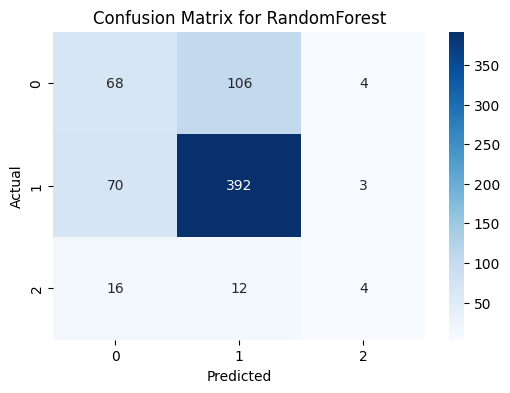


Confusion Matrix for GradientBoosting:
[[ 62  99  17]
 [106 345  14]
 [ 15   9   8]]


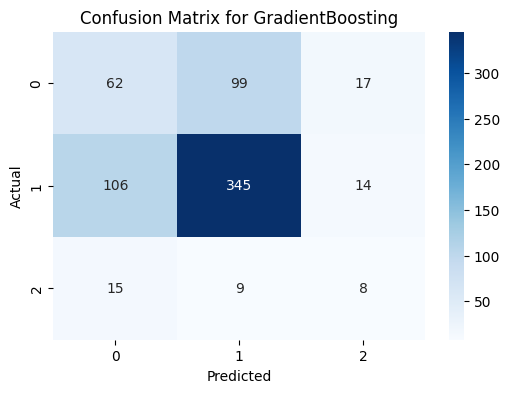


Confusion Matrix for LogisticRegression:
[[ 55 109  14]
 [ 57 397  11]
 [ 13  10   9]]


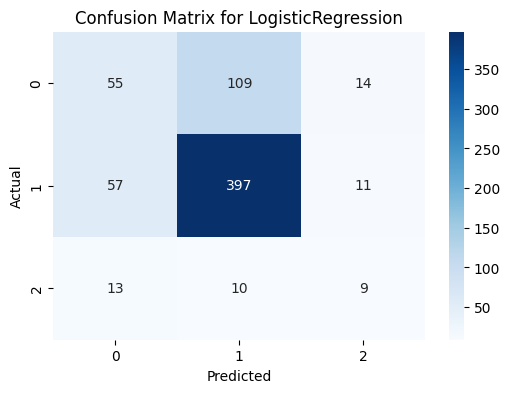


Confusion Matrix for SVC_linear:
[[ 47 124   7]
 [ 43 414   8]
 [ 12  11   9]]


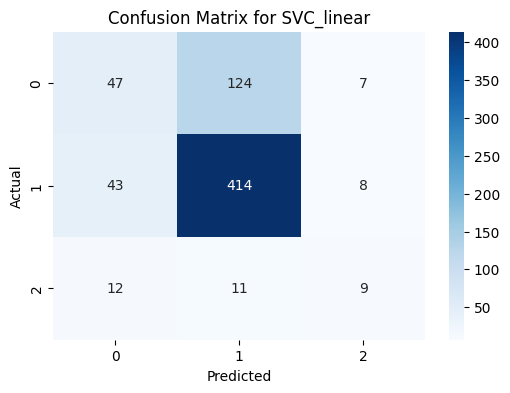


Confusion Matrix for SVC_rbf:
[[  0 178   0]
 [  6 459   0]
 [  0  32   0]]


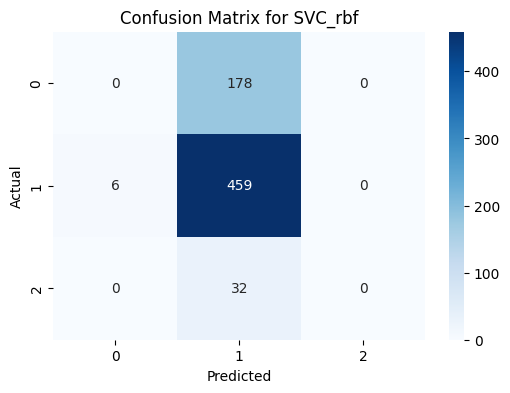

In [10]:
if ML == True:

  import matplotlib.pyplot as plt
  import seaborn as sns
  from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
  from sklearn.linear_model import LogisticRegression
  from sklearn.svm import SVC
  from sklearn.metrics import accuracy_score, confusion_matrix

  # Define predictors and target using the given column lists
  predictors = FEATURES
  target = TRUE_REGIME

  # Drop rows with missing values in predictors or target
  data = input_df.dropna(subset=predictors + [target]).reset_index(drop=True)
  X = data[predictors]
  y = data[target]
  # Also grab the DATE column for printing prediction timestamps
  dates = data[DATE]

  # Define the models
  models = {
      'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
      'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
      'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
      'SVC_linear': SVC(kernel='linear', probability=True, random_state=42),
      'SVC_rbf': SVC(kernel='rbf', probability=True, random_state=42)
  }

  window_size = 60  # e.g., 60 observations for training
  rolling_accuracies = {name: [] for name in models}

  # Dictionaries to store true and predicted labels for each model for confusion matrix calculation
  pred_true = {name: {'y_true': [], 'y_pred': []} for name in models}

  print("Starting rolling window evaluation:")

  # Loop over the dataset in a rolling window manner
  for i in range(len(X)):
      if i < window_size:
          print(f"Skipping prediction for timestamp {dates.iloc[i]} "
                f"(insufficient data: {i} observations available, need {window_size}).")
          continue

      # Training period is the previous window_size observations
      # Training period ends at the date corresponding to index i-1
      train_end = dates.iloc[i-1]
      # The prediction is for the date at index i
      test_date = dates.iloc[i]

      X_train_window = X.iloc[i-window_size:i]
      y_train_window = y.iloc[i-window_size:i]
      X_test_window = X.iloc[[i]]
      y_test_window = y.iloc[[i]]

      # Loop through each model, fit, predict and print the training end date and prediction date
      for name, model in models.items():
          model.fit(X_train_window, y_train_window)
          y_pred = model.predict(X_test_window)
          acc = accuracy_score(y_test_window, y_pred)
          print(f"Training period ended at {train_end} - Prediction for period {test_date}: "
                f"Model '{name}' Accuracy = {acc:.2f}")
          rolling_accuracies[name].append(acc)
          # Save true and predicted values for confusion matrix calculation
          pred_true[name]['y_true'].append(y_test_window.values[0])
          pred_true[name]['y_pred'].append(y_pred[0])

  # Print average rolling window accuracy for each model
  print("\nRolling Window Average Accuracy:")
  for name, acc_list in rolling_accuracies.items():
      avg_acc = np.mean(acc_list) if acc_list else 0
      print(f"{name}: {avg_acc:.2f}")

  # Compute and display confusion matrix for each model
  for name in models:
      cm = confusion_matrix(pred_true[name]['y_true'], pred_true[name]['y_pred'])
      print(f"\nConfusion Matrix for {name}:")
      print(cm)

      # Plot confusion matrix heatmap
      plt.figure(figsize=(6, 4))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
      plt.title(f'Confusion Matrix for {name}')
      plt.ylabel('Actual')
      plt.xlabel('Predicted')
      plt.show()


In [11]:
if DL == True:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
    import xgboost as xgb
    from sklearn.metrics import confusion_matrix, accuracy_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Parameters:
    training_window = 120  # Use the previous 120 months as training data
    seq_len = 60           # Generate overlapping sequences of 60 months within the training window
    num_classes = cluster_n  # Regimes are assumed to be labeled 0, 1, 2
    num_features = len(FEATURES)

    all_preds = []   # To store predictions
    all_true = []    # To store true regime labels
    dates_list = []  # To store corresponding dates

    # Ensure data is sorted by date
    data = input_df.sort_values(DATE).reset_index(drop=True)

    # Rolling window: start at index = training_window until end of data
    for i in range(training_window, len(data)):
        # Use the previous 120 months as the training window
        train_window = data.iloc[i - training_window:i].reset_index(drop=True)
        if len(train_window) < training_window:
            continue

        # Generate overlapping sequences of length 60 within the training window
        X_train_sequences = []
        y_train = []
        for j in range(len(train_window) - seq_len + 1):
            seq = train_window[FEATURES].iloc[j : j + seq_len].values
            target = train_window[TRUE_REGIME].iloc[j + seq_len - 1]  # target is the regime at the end of the sequence
            X_train_sequences.append(seq)
            y_train.append(target)
        X_train_sequences = np.array(X_train_sequences)  # shape: (num_samples, seq_len, num_features)
        y_train = np.array(y_train)

        # Build an LSTM feature extractor model using an Input layer
        input_layer = Input(shape=(seq_len, num_features))
        lstm_out = LSTM(32, return_sequences=False)(input_layer)
        dropout_out = Dropout(0.2)(lstm_out)
        feature_extractor = Model(inputs=input_layer, outputs=dropout_out)

        # Extract features from the training sequences
        X_train_features = feature_extractor.predict(X_train_sequences, verbose=0)

        # Train an XGBoost classifier on these features.
        clf = xgb.XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='mlogloss')
        clf.fit(X_train_features, y_train)

        # For prediction, use the last 60-month sequence in the training window
        X_pred_seq = train_window[FEATURES].iloc[-seq_len:].values.reshape(1, seq_len, num_features)
        X_pred_feature = feature_extractor.predict(X_pred_seq, verbose=0)
        pred_regime = clf.predict(X_pred_feature)[0]

        # The true regime for the next month (time index i)
        true_regime = data[TRUE_REGIME].iloc[i]

        all_preds.append(pred_regime)
        all_true.append(true_regime)
        dates_list.append(data[DATE].iloc[i])

        print(f"Prediction for {data[DATE].iloc[i]}: Predicted={pred_regime}, True={true_regime}")

    # Compute overall accuracy
    accuracy = accuracy_score(all_true, all_preds)
    print(f"\nOverall Accuracy: {accuracy*100:.2f}%")

    # Create and visualize the confusion matrix
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Rolling Window Hybrid (LSTM + XGBoost) Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
